In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

from tqdm import tqdm

plt.rcParams.update({'figure.figsize': (15, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [126]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date', usecols=['Balance', 'Date'])

In [127]:
df

Balance
Date                
2017-01-09 -0.155904
2017-01-10 -0.125572
2017-01-11  0.007767
2017-01-12  0.800391
2017-01-13 -0.019721
...              ...
2021-03-27  0.000000
2021-03-28  0.000000
2021-03-29 -1.017679
2021-03-30 -0.259687
2021-03-31 -0.004878

[1543 rows x 1 columns]

# График временного ряда

<Axes: xlabel='Date'>

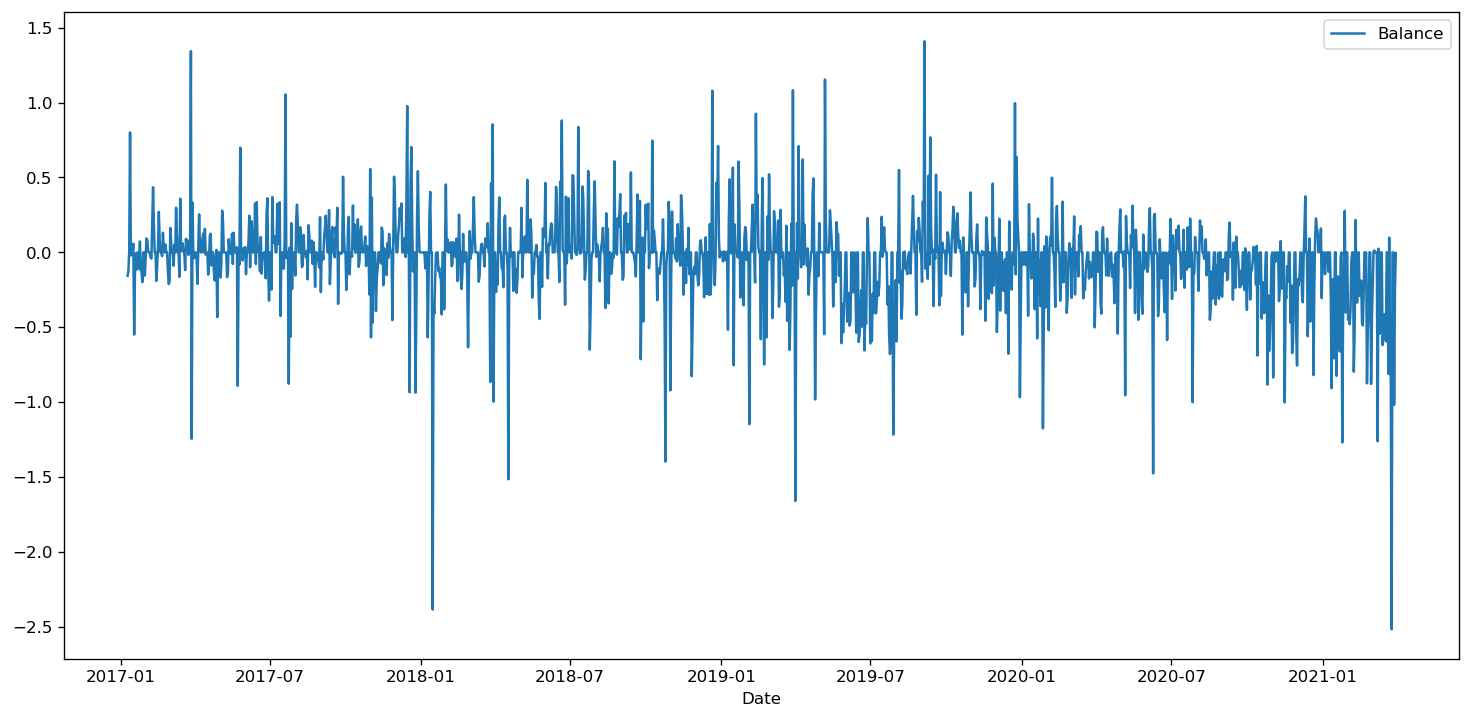

In [4]:
sns.lineplot(df)

# Разбиение данных

In [128]:
start_date = df.index[0]
threshold_date = np.datetime64('2019-07-30')
end_date = df.index[-1]#np.datetime64('2020-09-11')

In [129]:
df = df[df.index <= end_date]

In [130]:
mask_before = (df.index < threshold_date) & (df.index >= start_date)
mask_after = (df.index >= threshold_date) & (df.index <= end_date)

# Тест Дики-Фуллера для проверки на стационарность

In [ ]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


In [ ]:
check_stationarity(df.Balance[mask_before])

ADF Statistic: -7.279939
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Stationary


In [ ]:
check_stationarity(df.Balance[mask_after])

ADF Statistic: -2.845647
p-value: 0.052043
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Non-stationary


https://forecastegy.com/posts/change-point-detection-time-series-python/

In [ ]:
# Тут реализована модификация статистики взвешенного экспоненциального среднего.
class MeanExpNoDataException(Exception):
    pass


class MeanExp(object):
    def __init__(self, new_value_weight, load_function=np.median):
        self._load_function = load_function
        self._new_value_weight = new_value_weight
        self.load([])

    @property
    def value(self):
        if self._weights_sum <= 1:
            raise MeanExpNoDataException('self._weights_sum <= 1')
        return self._values_sum / self._weights_sum

    def update(self, new_value, **kwargs):
        self._values_sum = (1 - self._new_value_weight) * self._values_sum + new_value
        self._weights_sum = (1 - self._new_value_weight) * self._weights_sum + 1.0

    def load(self, old_values):
        if old_values:
            old_values = [value for ts, value in old_values]
            mean = float(self._load_function(old_values))
            self._weights_sum = min(float(len(old_values)), 1.0 / self._new_value_weight)
            self._values_sum = mean * self._weights_sum
        else:
            self._values_sum = 0.0
            self._weights_sum = 0.0

In [ ]:
class Stat(object):
    def __init__(self, threshold, direction="unknown", init_stat=0.0):
        self._direction = str(direction)
        self._threshold = float(threshold)
        self._stat = float(init_stat)
        self._alarm = self._stat / self._threshold
    
    @property
    def direction(self):
        return self._direction

    @property
    def stat(self):
        return self._stat
        
    @property
    def alarm(self):
        return self._alarm
        
    @property
    def threshold(self):
        return self._threshold
    
    def update(self, **kwargs):
        # Statistics may use any of the following kwargs:
        #   ts - timestamp for the value
        #   value - original value
        #   mean - current estimated mean
        #   std - current estimated std
        #   adjusted_value - usually (value - mean) / std
        # Statistics call this after updating '_stat'
        self._alarm = self._stat / self._threshold

In [ ]:
class AdjustedShiryaevRoberts(Stat):
    def __init__(self, mean_diff, threshold, max_stat=float("+inf"), init_stat=0.0):
        super(AdjustedShiryaevRoberts, self).__init__(threshold,
                                                      direction="up",
                                                      init_stat=init_stat)
        self._mean_diff = mean_diff
        self._max_stat = max_stat

    def update(self, adjusted_value, **kwargs):
        likelihood = np.exp(self._mean_diff * (adjusted_value - self._mean_diff / 2.))
        self._stat = min(self._max_stat, (1. + self._stat) * likelihood)
        Stat.update(self)

In [ ]:
alpha = 0.01
beta = 0.05
sigma_diff = 2.0

stat_trajectory, mean_values, var_values, diff_values = [], [], [], []
timestamps, values, changepoint = [], [], []

mean_exp = MeanExp(new_value_weight=alpha)
var_exp = MeanExp(new_value_weight=beta)
sr = AdjustedShiryaevRoberts(sigma_diff, 1000., max_stat=1e9)
for ts, x_k in zip(df.index, df.Balance):
    timestamps.append(ts)
    values.append(x_k)
    try:
        mean_estimate = mean_exp.value
    except MeanExpNoDataException:
        mean_estimate = 0.
    
    try:
        var_estimate = var_exp.value
    except MeanExpNoDataException:
        var_estimate = 1.
    
    predicted_diff_value = (x_k - mean_estimate) ** 2
    predicted_diff_mean = var_estimate
    sr.update(predicted_diff_value - predicted_diff_mean)
    diff_values.append(predicted_diff_value - predicted_diff_mean)
    
    mean_exp.update(x_k)
    diff_value = (x_k - mean_estimate) ** 2
    var_exp.update(diff_value)
    
    stat_trajectory.append(sr._stat)
    mean_values.append(mean_estimate)
    var_values.append(np.sqrt(var_estimate))

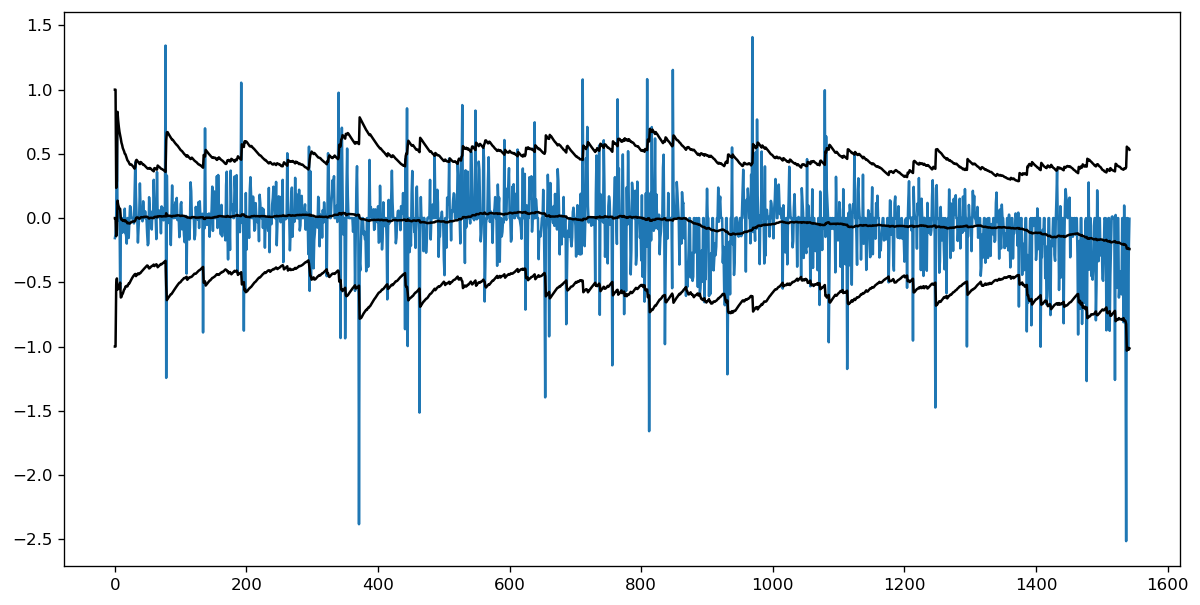

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(np.array(mean_values), 'k')
plt.plot(np.array(mean_values) + np.sqrt(var_values), 'k')
plt.plot(np.array(mean_values) - np.sqrt(var_values), 'k')

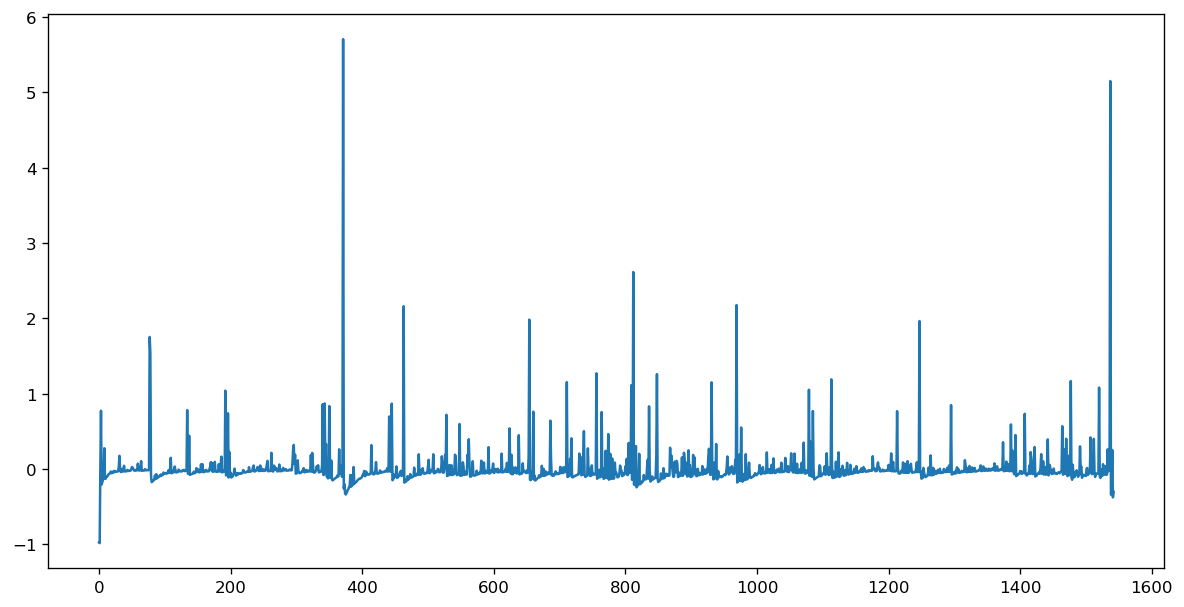

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(diff_values)

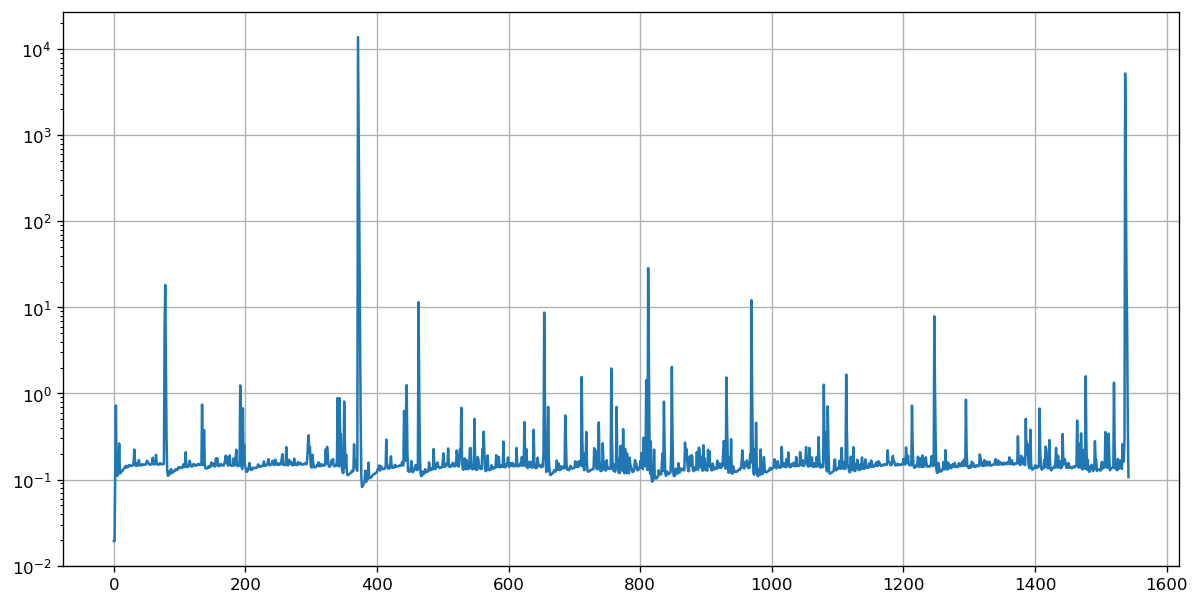

In [ ]:
plt.figure(figsize=(12, 6))
plt.semilogy(stat_trajectory)
plt.grid('on')

# Избавляемся от выбросов

<Axes: xlabel='Date', ylabel='Balance'>

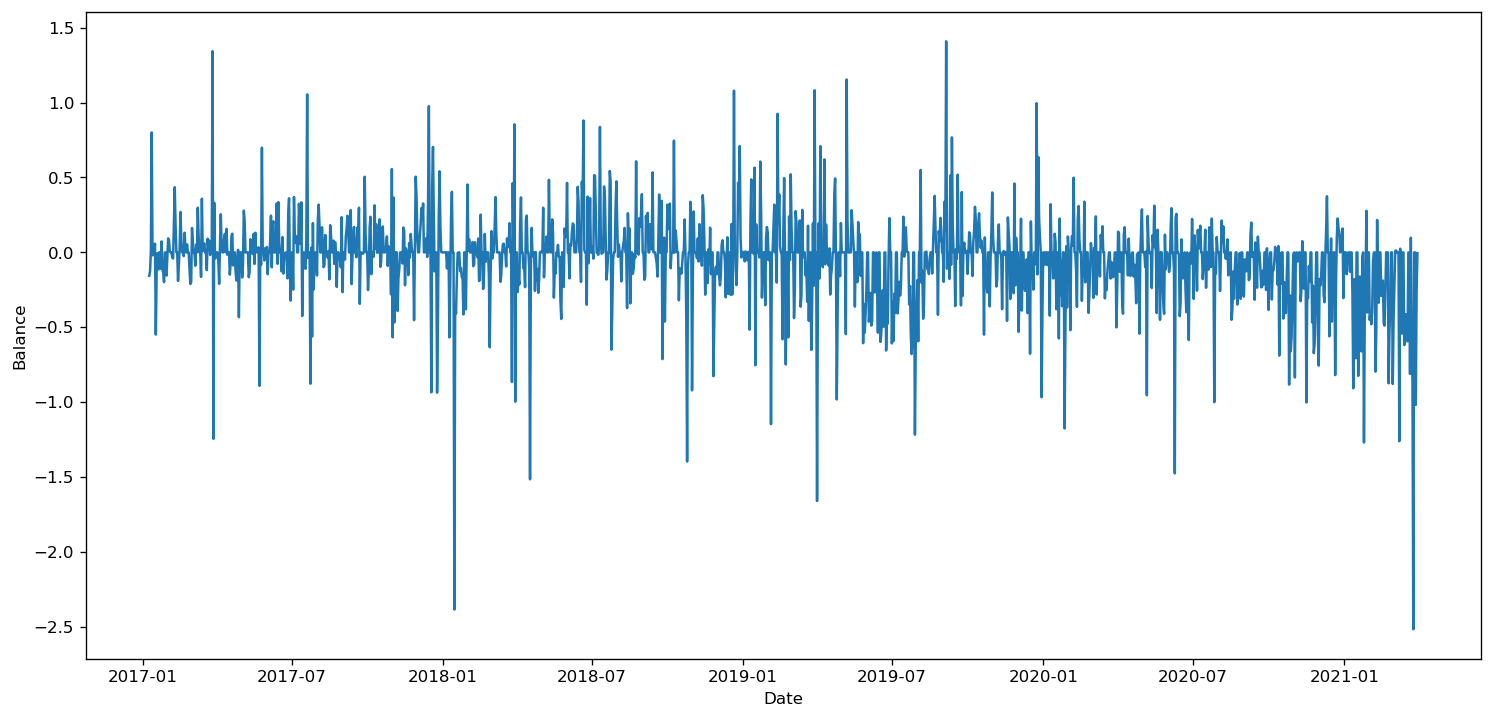

In [131]:
sns.lineplot(x = df.index, y = df.Balance)

In [132]:
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

Balance_balanced = zscore(df.Balance, window=50)

<Axes: xlabel='Date', ylabel='Balance'>

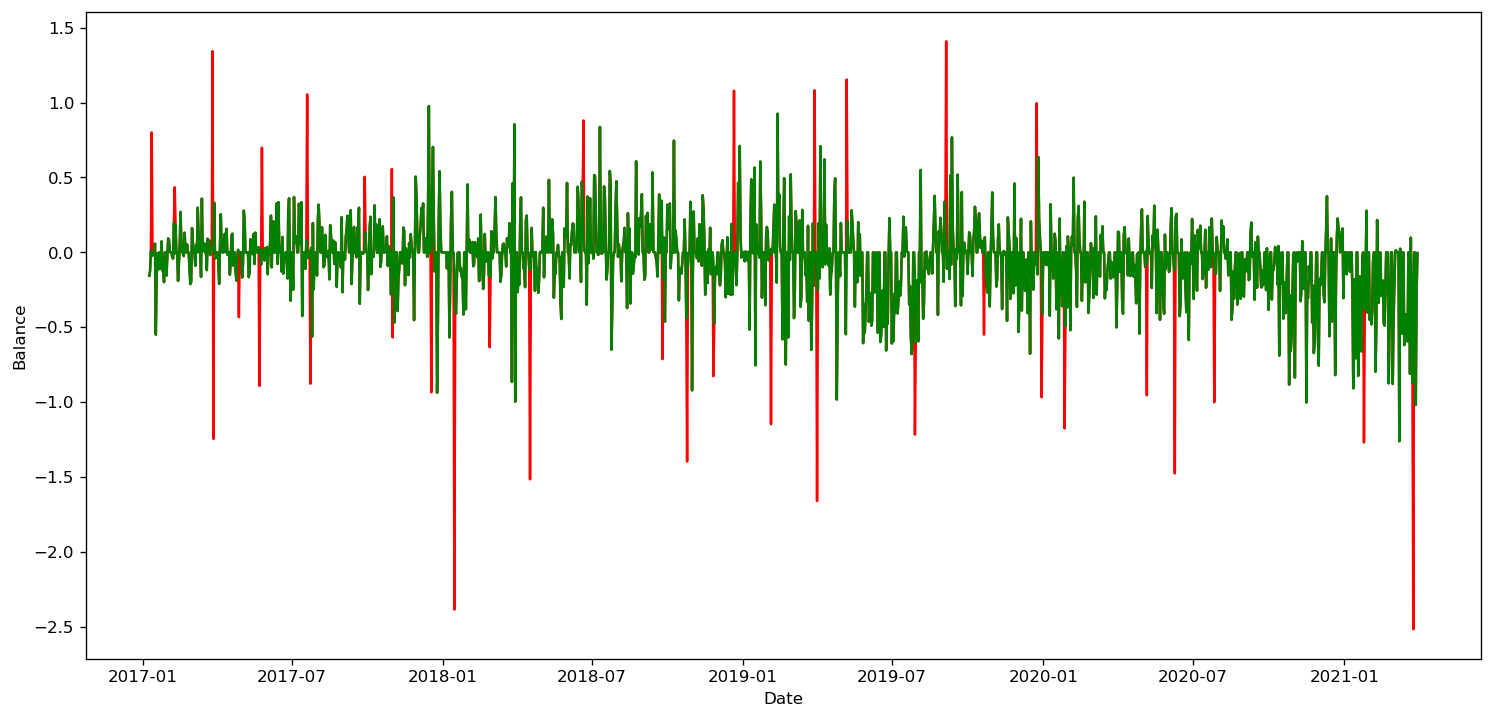

In [133]:
sns.lineplot(df.Balance, color='red')
sns.lineplot(Balance_balanced, color='green')

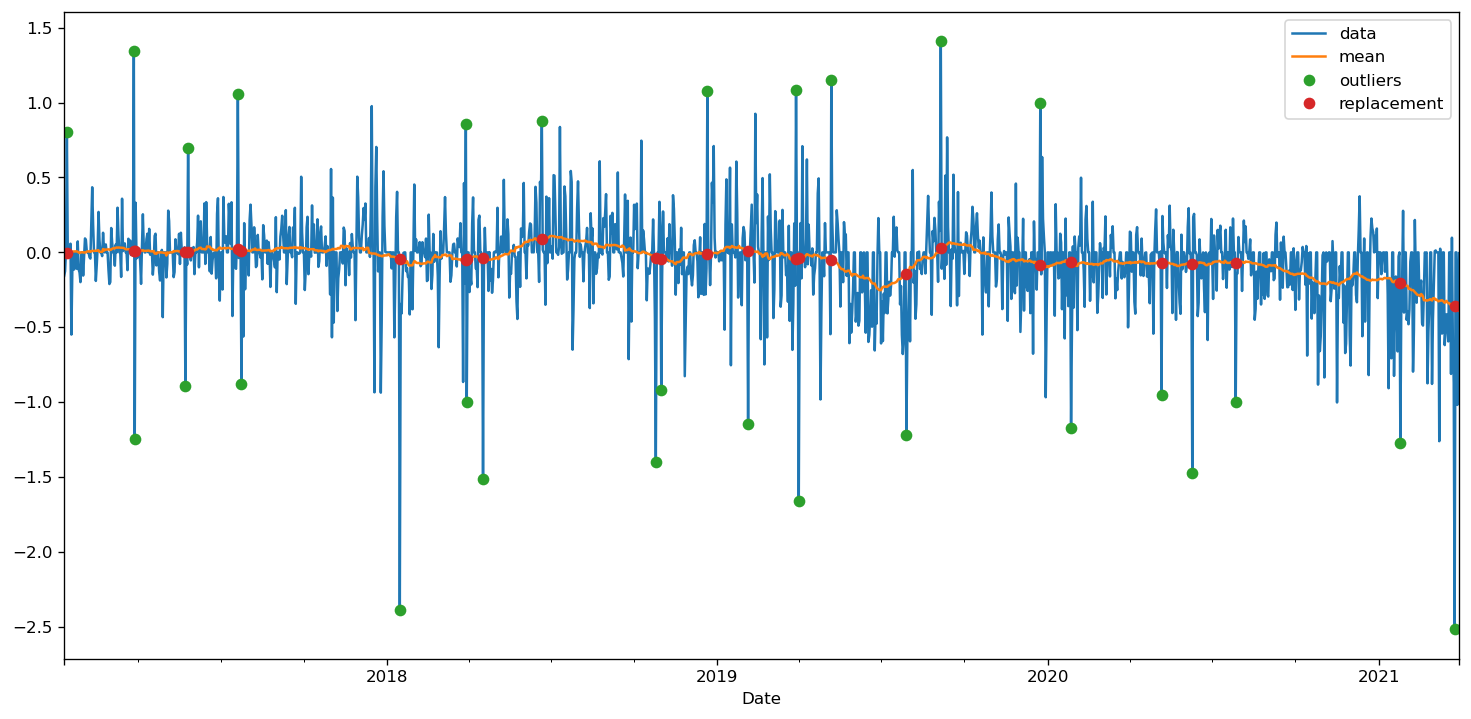

In [134]:
z, avg, std, m = zscore(df.Balance, window=70, return_all=True)

ax = plt.subplot()

df.Balance.plot(label='data')
avg.plot(label='mean')
df.loc[~m, 'Balance'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()

Замену можно провести, все найс

In [135]:
df.Balance = Balance_balanced

<Axes: xlabel='Date', ylabel='Balance'>

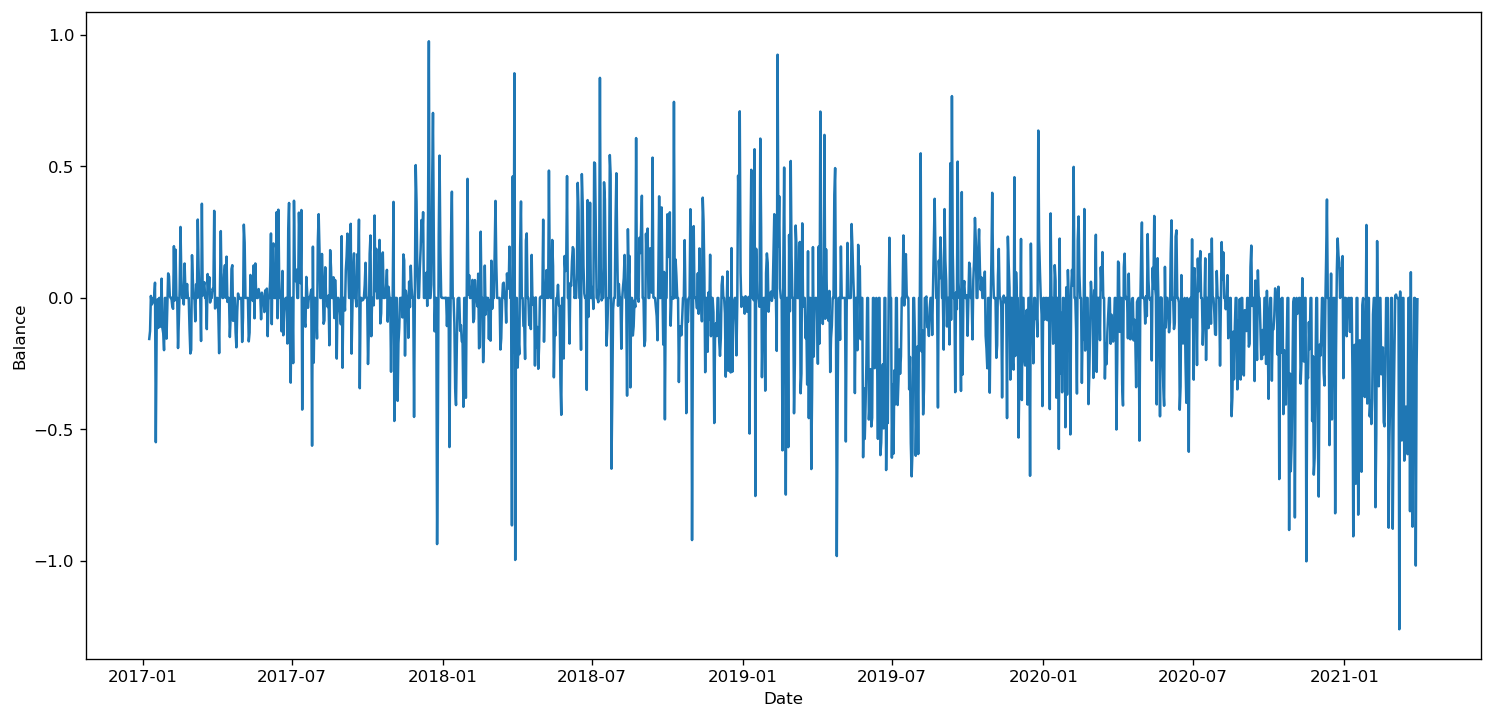

In [136]:
sns.lineplot(df.Balance)

https://stackoverflow.com/questions/75938497/outlier-detection-of-time-series-data

# Разложение на компоненты (попытка)

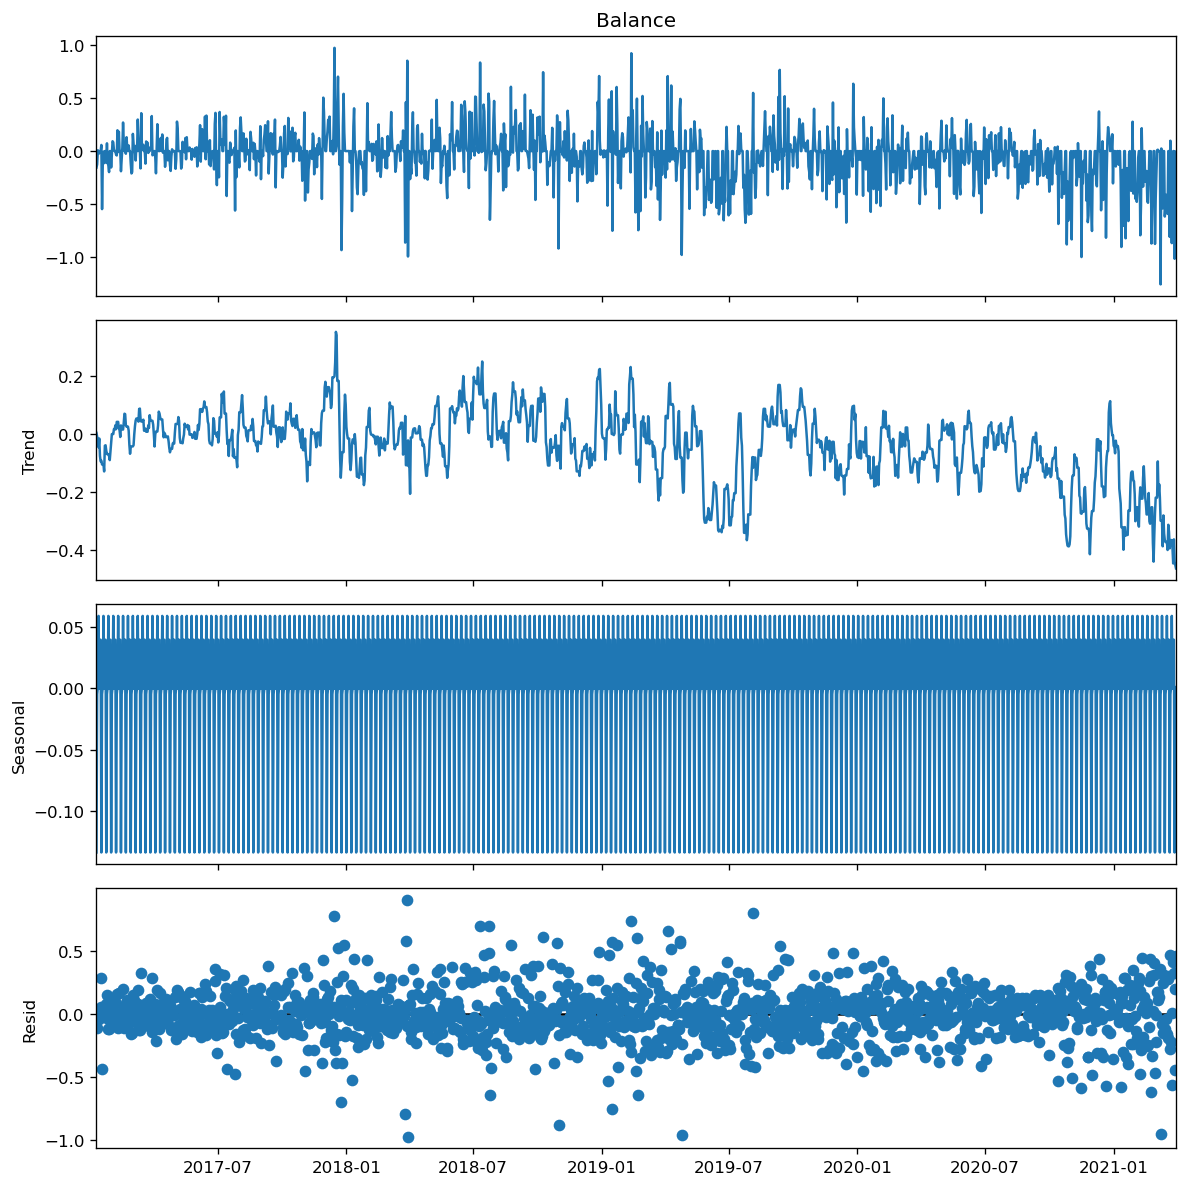

In [ ]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
seasonal = result_add.seasonal
plt.show()

In [ ]:
BalanceD1 = (df.Balance - df.Balance.shift(7))[7:]

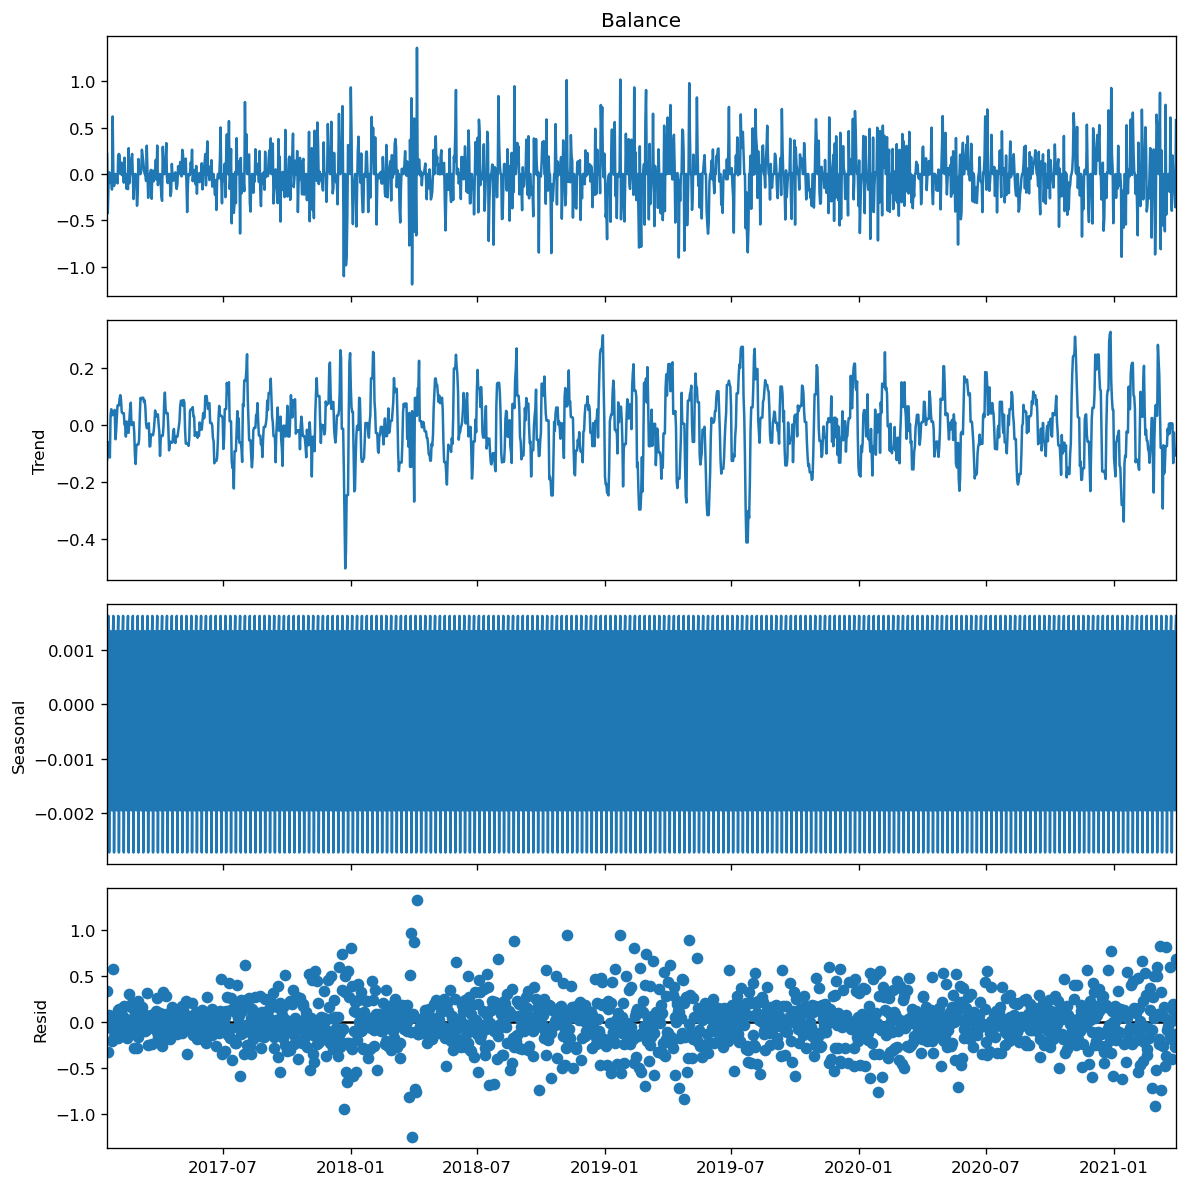

In [ ]:
# Additive Decomposition
result_add2 = seasonal_decompose(BalanceD1, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add2.plot()
seasonal2 = result_add2.seasonal
plt.show()

<Axes: xlabel='Date', ylabel='seasonal'>

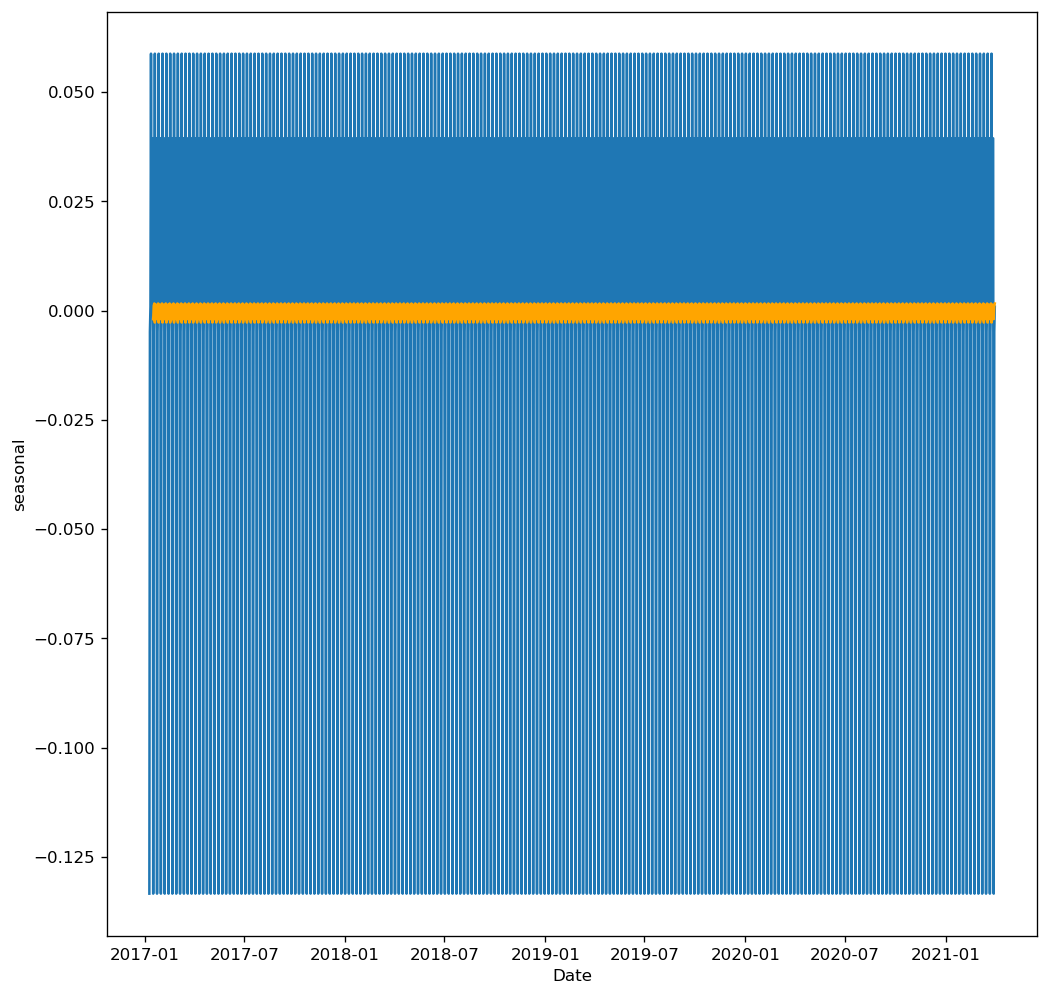

In [ ]:
sns.lineplot(seasonal)
sns.lineplot(seasonal2, color='orange')

Сезонная компонента уменьшена

In [ ]:
BalanceD2 = (BalanceD1 - BalanceD1.shift(7))[7:]

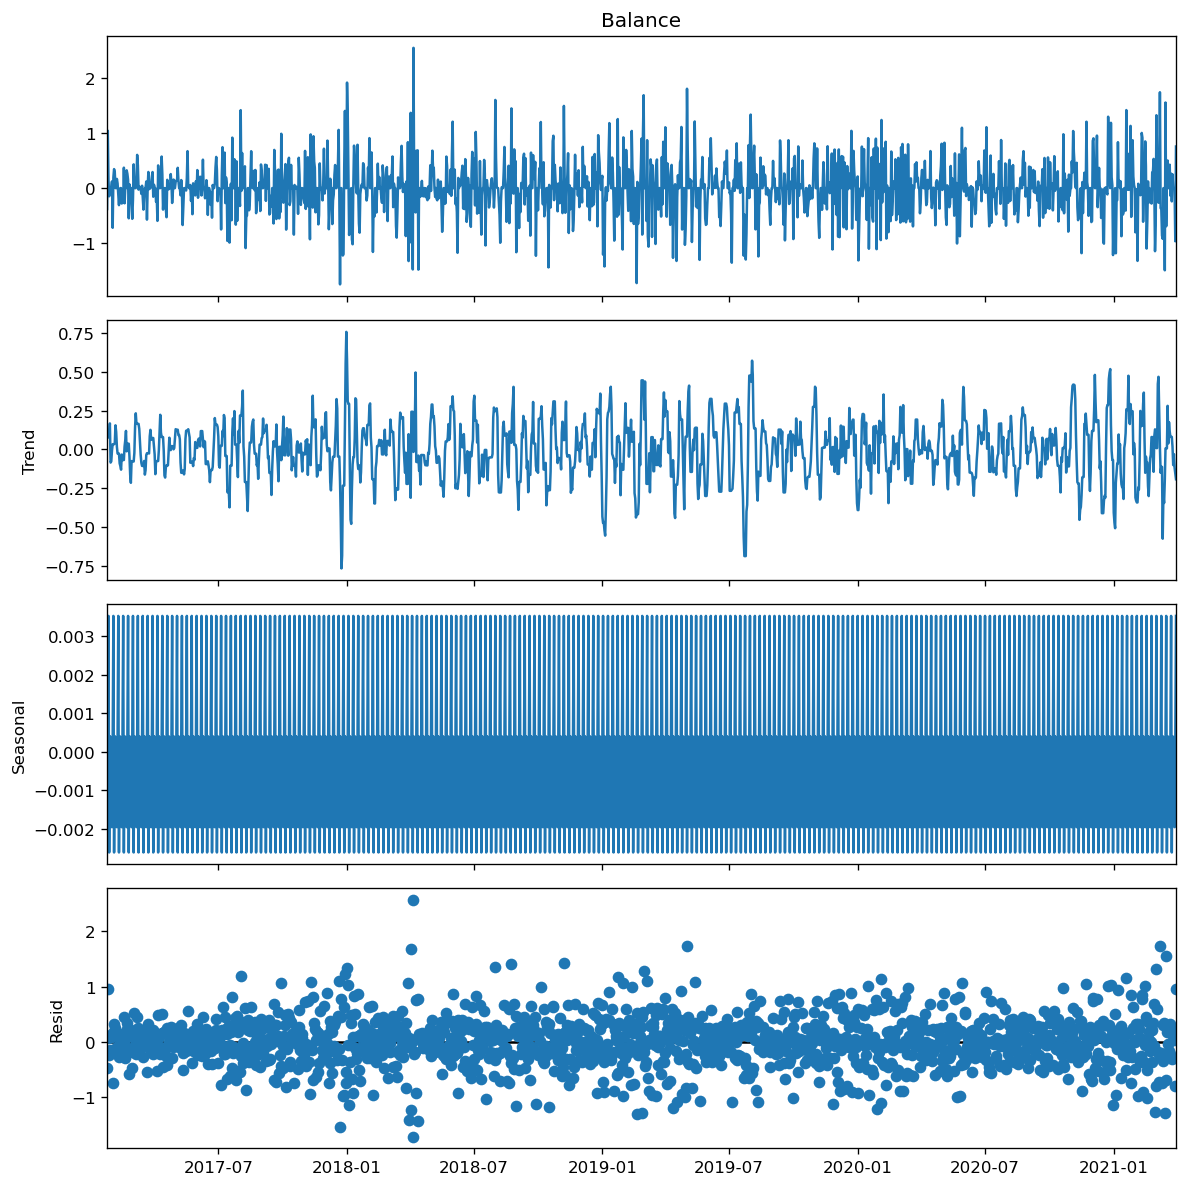

In [ ]:
# Additive Decomposition
result_add3 = seasonal_decompose(BalanceD2, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add3.plot()
seasonal3 = result_add2.seasonal
plt.show()

<Axes: xlabel='Date', ylabel='seasonal'>

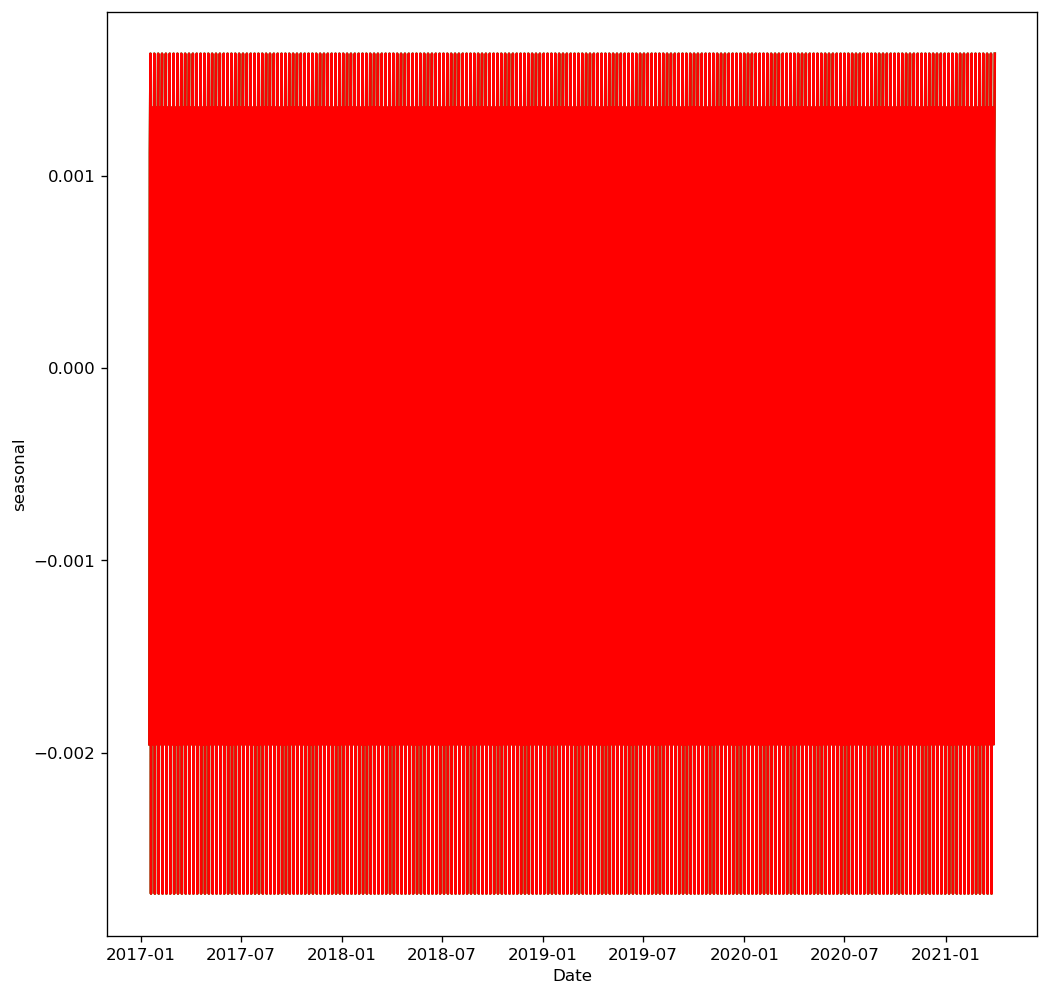

In [ ]:
sns.lineplot(seasonal2, color='green')
sns.lineplot(seasonal3, color='red')

Толковых изменений нет

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

In [ ]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise


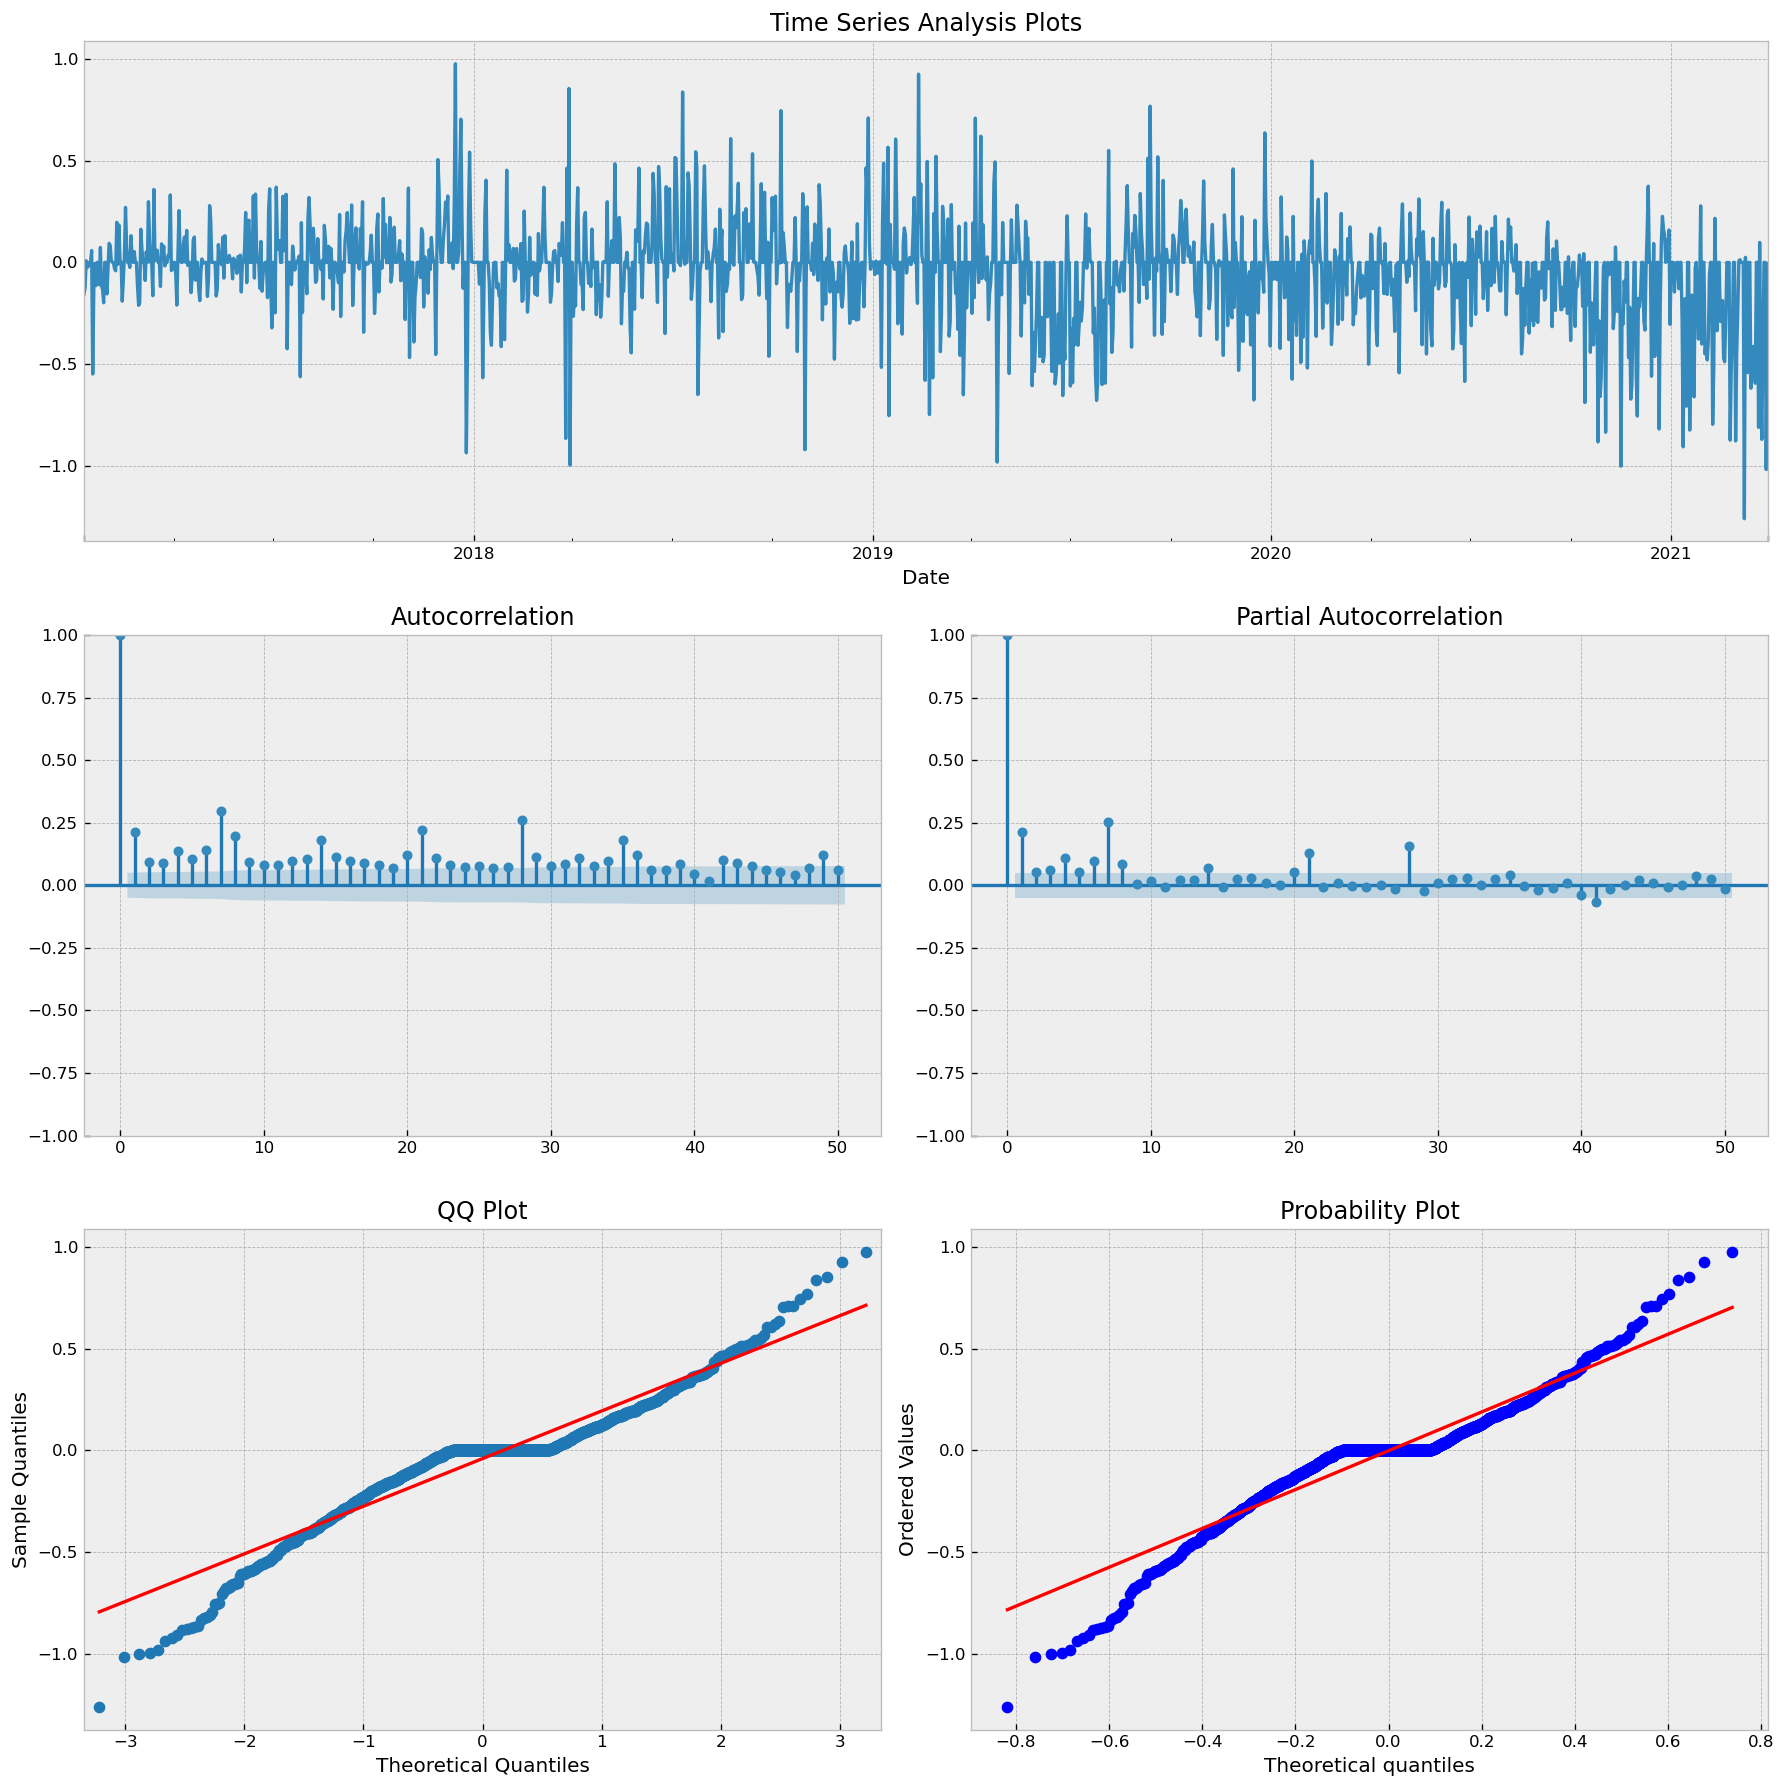

In [ ]:
tsplot(df.Balance, lags=50)

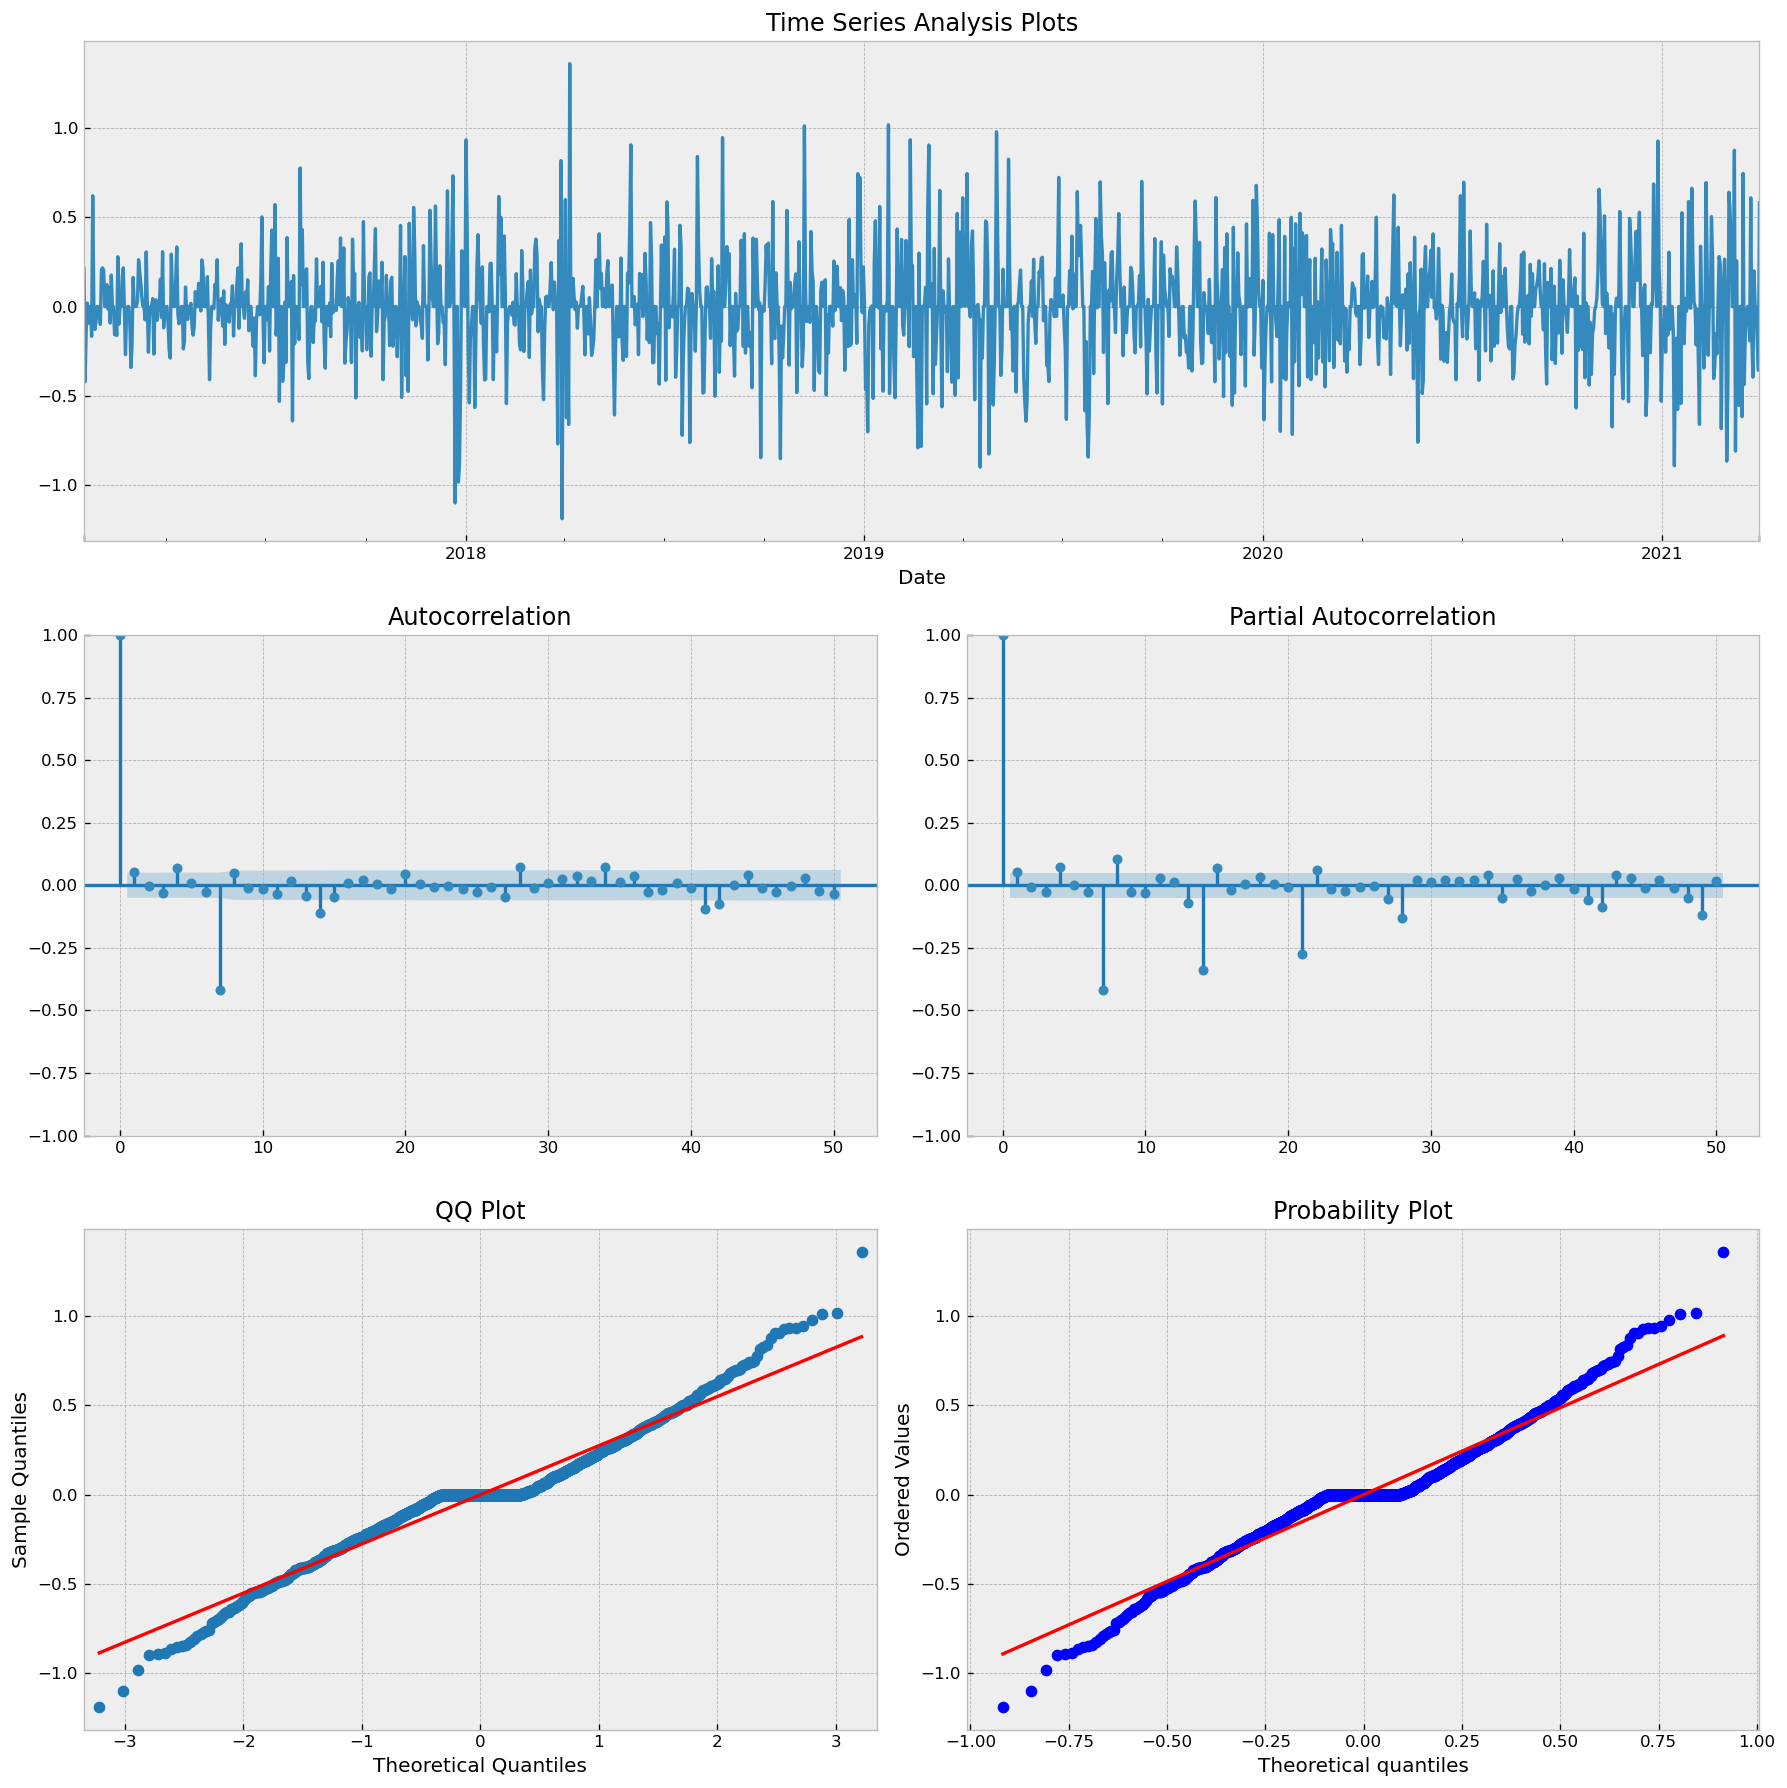

In [ ]:
tsplot(BalanceD1, lags=50)

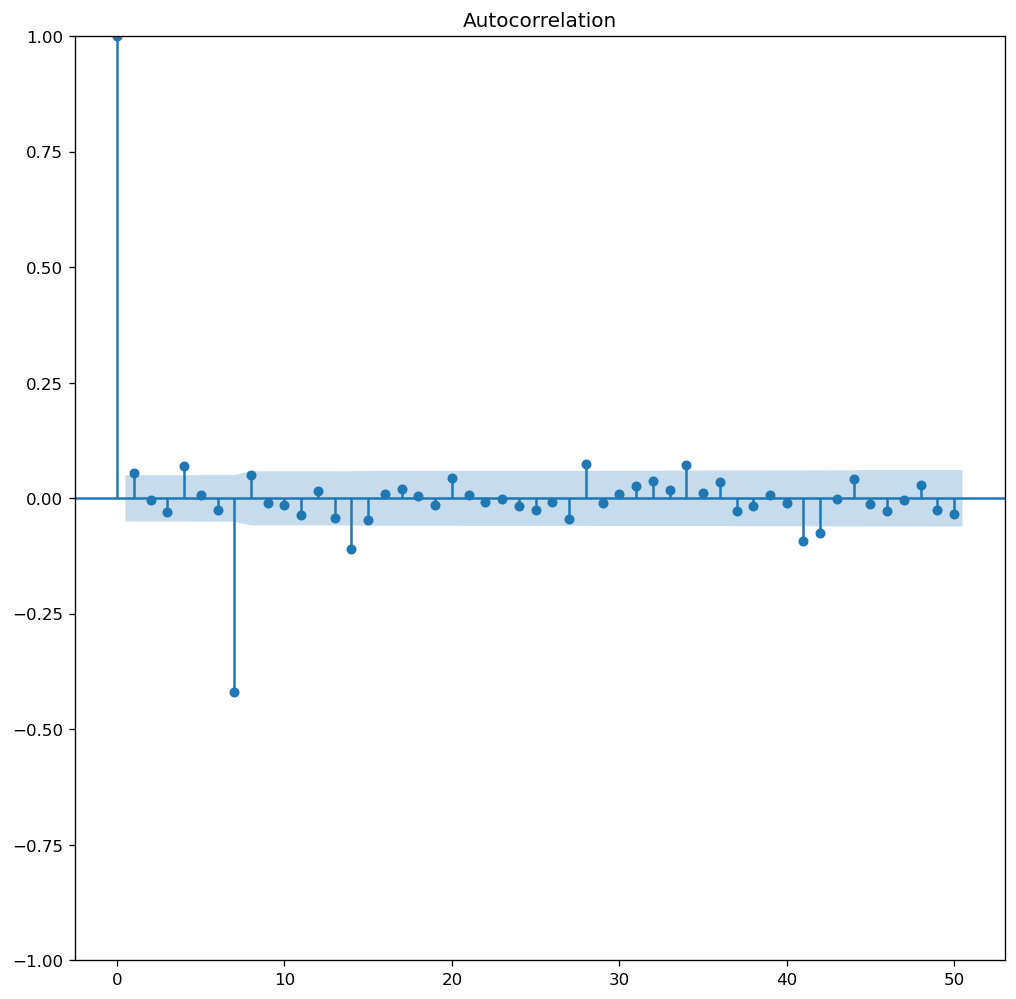

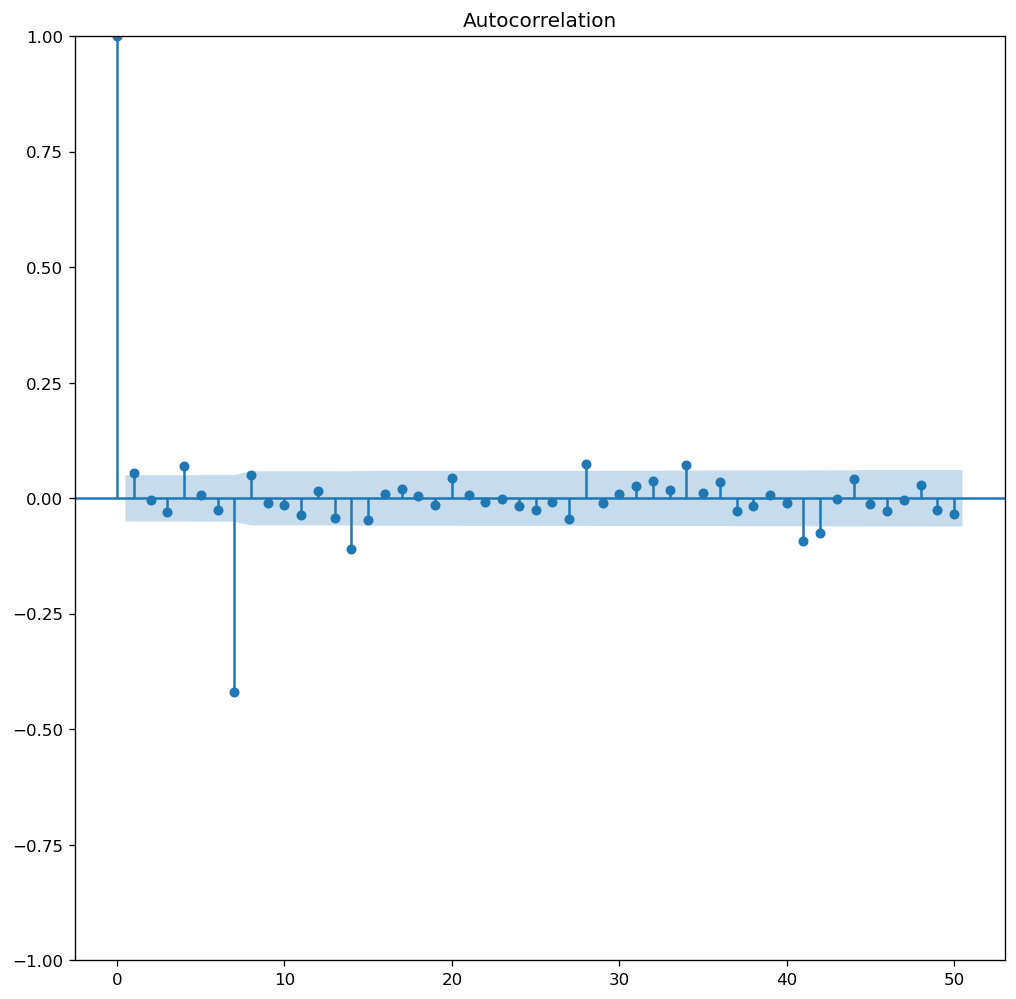

In [ ]:
sm.graphics.tsa.plot_acf(BalanceD1, lags=50, alpha=0.05)

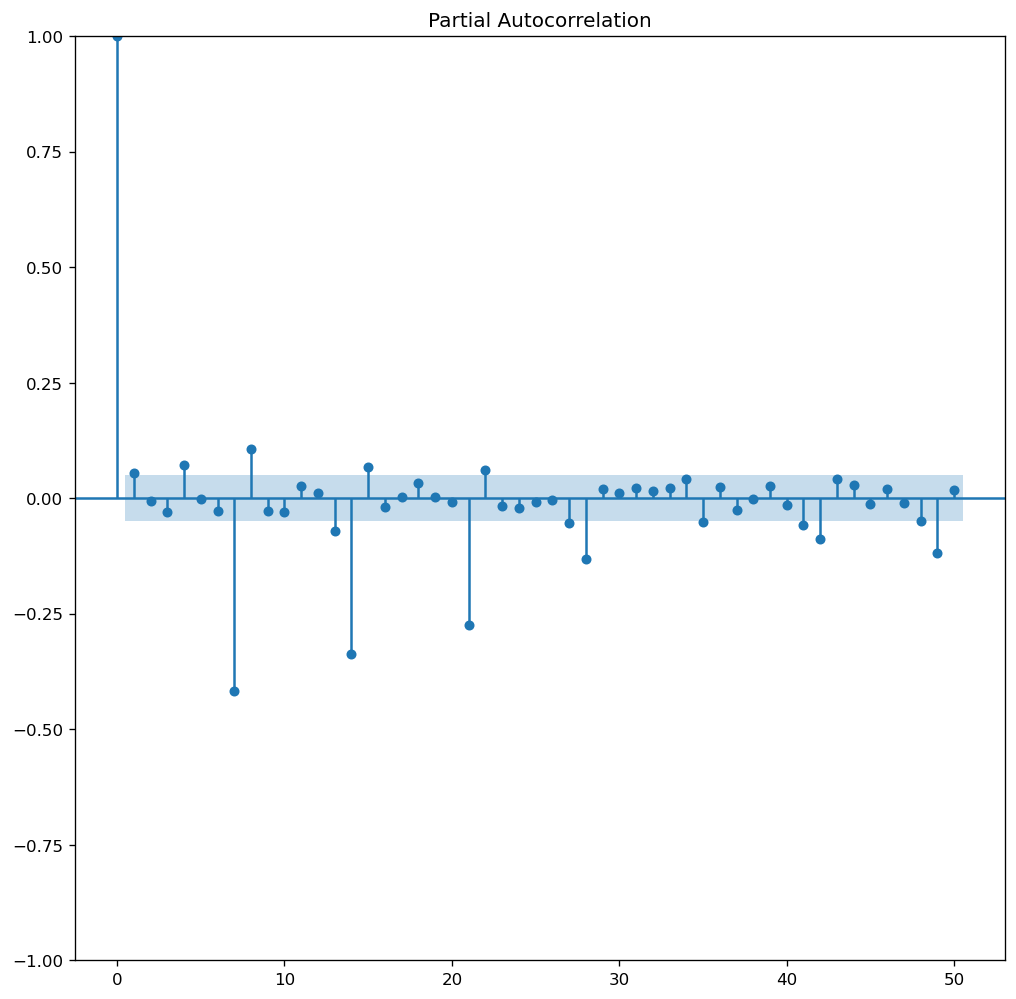

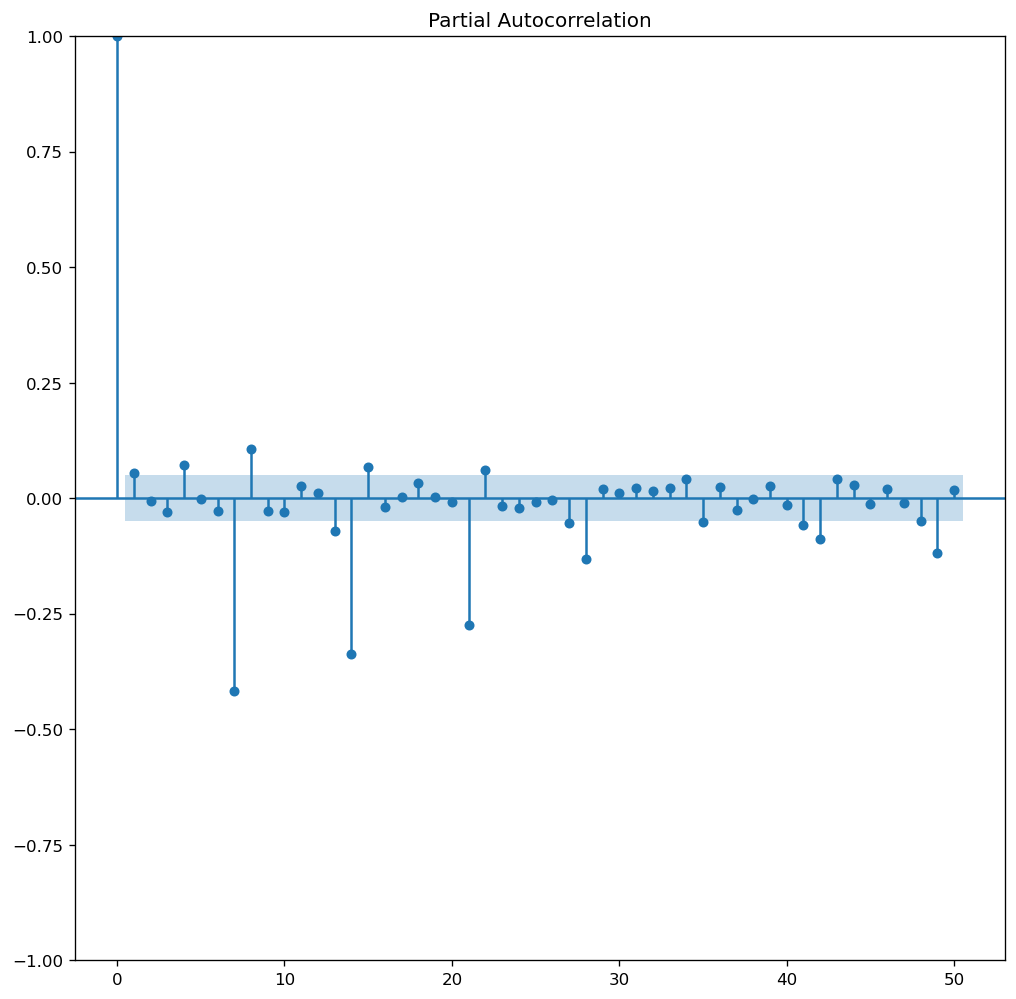

In [ ]:
sm.graphics.tsa.plot_pacf(BalanceD1, lags=50, alpha=0.05)

Похоже на SARIMA(p=2, i=0, q=2, P=5, I=0, Q=1, S=7)

# Моделирование

In [ ]:
import itertools
import math
from sklearn.metrics import r2_score, mean_absolute_error

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 4)  # Moving average order
P_values = range(0, 5) # Seasonal autoregressive order
D_values = [1]  # Seasonal differencing order
Q_values = range(0, 3)  # Seasonal moving average order
m_values = [7]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))
results_exog = []

# Initialize AIC with a large value
best_aic_SARIMA = float("inf")  
best_params_SARIMAX = None
best_SARIMA = None

warnings.filterwarnings('ignore')


# Perform grid search
for params in tqdm(param_combinations):
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model_chosen = ARIMA(endog=df[mask_before].Balance, 
                               order=order, 
                               seasonal_order=seasonal_order)
        model_chosen = model_chosen.fit()
        aic = model_chosen.aic
        
        # Ensure the convergence of the model
        if not math.isinf(model_chosen.zvalues.mean()):
            predict=model_chosen.predict(start=threshold_date, end=end_date, exog=None)
            err_max = (df.Balance[mask_after]-predict).abs().max()
            mae = mean_absolute_error(df.Balance[mask_after], predict)
            llf = model_chosen.llf
            r2 = r2_score(df.Balance[mask_after], predict)
            aic = model_chosen.aic
            if aic < best_aic_SARIMA:
                best_aic_SARIMA = aic
                best_params_SARIMA = params
                best_SARIMA = model_chosen
                best_err_max = err_max
                best_mae = mae
                best_llf = llf
                best_r2 = r2
                best_combination = params
            results_exog.append(list(params[:-1]) + [err_max, mae, llf, r2, aic])
        else:
            print(order, seasonal_order, 'not converged')
    except ValueError:
        print('wrong parameters:', params)
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params_SARIMA)
print("Best AIC:", best_aic_SARIMA)

 15%|█▌        | 37/240 [00:42<03:54,  1.15s/it]


KeyboardInterrupt: 

In [ ]:
result_table = pd.DataFrame(results_exog)
result_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'MAE', 'LLF', 'R2', 'aic']
print("by LLF:")
display(result_table.sort_values(by=['LLF'], ascending=False).head(1))
print("by err_max:")
display(result_table.sort_values(by=['err_max'], ascending=True).head(1))
print("by MAE:")
display(result_table.sort_values(by=['MAE'], ascending=True).head(1))
print("by aic:")
display(result_table.sort_values(by=['aic'], ascending=True).head(1))
print("by R2:")
display(result_table.sort_values(by=['R2'], ascending=False).head(1))

In [ ]:
best_SARIMA.summary()

In [ ]:
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs

# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(df.Balance,
            m=10,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
D

In [ ]:
import pmdarima as pm
best_auto = pm.AutoARIMA(
                        # test='adf',
                        # start_p=0, max_p=4,
                        # d=0,
                        # start_q=0, max_q=4,
                        # start_P=0, max_P=5,
                        start_D=0, max_D=2,
                        # start_Q=0, max_Q=5,
                        m=7,
                        seasonal=True,
                        stationary=True,
                        trace=True,
                        suppress_warnings=True,
                        error_action='ignore',
                        stepwise=True
                      ).fit(y=df.Balance[mask_before])


In [ ]:
best_auto.summary()

Максимальная и средняя ошибки для выбранной авто:

In [ ]:
predict_auto=best_auto.predict_in_sample(start=threshold_date, end=end_date)
err_auto = (df.Balance[mask_after]-predict_auto).abs()
print(err_auto.max(), err_auto.mean())

Максимальная и средняя ошибки для выбранной перебором:

In [ ]:
predict_chosen = best_SARIMA.predict(start=threshold_date, end=end_date)
err_chosen = (df.Balance[mask_after]-predict_chosen).abs()
print(err_chosen.max(), err_chosen.mean())

In [ ]:
sns.lineplot(x=df.index, y=df.Balance, label='test', color = 'purple')
sns.lineplot(x=df.index, y=best_SARIMA.predict(start=start_date, end=end_date), label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=df.index[mask_after], y=predict_auto, label='pred_auto', linestyle='dashed', color='black')

plt.axvline(x=threshold_date, color='limegreen')

In [ ]:
sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_auto).abs(), label='auto', color = 'green')
sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_chosen).abs(), label='chosen', color = 'red')
plt.axhline(y=0.5) 

In [ ]:
print(f"mean chosen = {(df.Balance[mask_after]-predict_chosen).abs().mean()}")
print(f"max chosen = {(df.Balance[mask_after]-predict_chosen).abs().max()}")

# Предположим мы взяли best_SARIMA модель

**Посмотрим как ведут себя остатки**

In [ ]:
result_add = seasonal_decompose((best_SARIMA.resid), model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# ARCH/GARCH

In [ ]:
tsplot(best_SARIMA.resid, lags=30)

https://medium.com/tej-api-financial-data-anlaysis/data-analysis-10-arima-garch-model-part-1-a011bf45f66c

In [ ]:
best_SARIMA.plot_diagnostics()

Проверим являются ли остатки белым шумом

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
arima_resid = best_SARIMA.resid
white_noise_arima = acorr_ljungbox(arima_resid, lags = [10], return_df=True)
white_noise_arima

In [ ]:
from statsmodels.stats.diagnostic import het_arch
LM_pvalue = het_arch(best_SARIMA.resid, ddof = 4)[1]
print('LM-test-Pvalue:', '{:.5f}'.format(LM_pvalue))

Т.к. p-value < 0.05, применим GARCH

In [ ]:
tsplot(best_SARIMA.resid**2, lags=30)

Пики на первом и седьмом шифте

In [ ]:
from arch import arch_model

ps = range(1,15)
qs = range(1,15)

params_variants = list(itertools.product(ps, qs))
results = []

for p, q in tqdm(params_variants):
    am = arch_model(best_SARIMA.resid, p=p, q=q).fit(update_freq=0)
    
    result = {
        'p': p,
        'q': q,
        'AIC': am.aic,
    }
    results.append(result)

results_df = pd.DataFrame(results)

best_model_aic = results_df.loc[results_df['AIC'].idxmin()]

display("Best GARCH model (AIC):")
display(best_model_aic)

In [ ]:
p = 8
q = 8
am = arch_model(best_SARIMA.resid, p=p, q=q).fit()
fig = am.plot()

In [ ]:
tsplot(am.resid)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
garch_resid = am.resid
white_noise_garch = acorr_ljungbox(garch_resid, lags = [10], return_df=True)
white_noise_garch

In [ ]:
sns.lineplot(best_SARIMA.resid)

In [ ]:
sns.lineplot(garch_resid)

P-value нормальные вроде, тогда берем в расход

https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff

In [ ]:
forecast_volatility = am.forecast(start=threshold_date-1, horizon=pd.Timedelta(end_date-threshold_date).days+1)
forecast_volatility_values = forecast_volatility.variance.values[0]

In [ ]:
upper_bound = predict_chosen + np.sqrt(forecast_volatility_values)
lower_bound = predict_chosen - np.sqrt(forecast_volatility_values)

In [ ]:
forecast_volatility.mean

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=df.index[mask_after], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red', ax=ax)


sns.lineplot(x=df.index[mask_after], y=upper_bound, label='bounds', color = 'magenta')
sns.lineplot(x=df.index[mask_after], y=lower_bound, label='bounds', color = 'magenta')
sns.lineplot(x=df.index[mask_after], y=df.Balance[mask_after], label='test', color = 'darkgreen')

In [ ]:
check_stationarity(df.Balance[mask_after])

# Попробуем зафигачить фичи дополнительные

## Курс доллара

In [137]:
print(df.index[0], df.index[-1])

2017-01-09 00:00:00 2021-03-31 00:00:00


In [138]:
USD_RUB_df = pd.read_csv(
    "/home/owner/Documents/DEV/Time_series/USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )

In [139]:
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

In [140]:
new_df = df.join(USD_RUB_df)
new_df

Balance      USD
Date                         
2017-01-09 -0.155904  60,0788
2017-01-10 -0.125572  60,1636
2017-01-11  0.007767  59,7256
2017-01-12 -0.025294  59,3491
2017-01-13 -0.019721  59,6869
...              ...      ...
2021-03-27  0.000000      NaN
2021-03-28  0.000000      NaN
2021-03-29 -1.017679  75,6648
2021-03-30 -0.259687  75,8495
2021-03-31 -0.004878  75,6987

[1543 rows x 2 columns]

In [141]:
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)

In [142]:
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)
new_df.USD = new_df.USD.shift(1)

## ВВП РФ по годам

In [143]:
GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (new_df.index.year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

## ВВП РФ по кварталам

In [144]:
GDP = pd.read_excel("/home/owner/Documents/DEV/Time_series/VVP_kvartal_s 1995-2023.xlsx", "2")[2:]
GDP = GDP.iloc[1]

offset = 4 * (2016-2011)
GDP = GDP[offset:]

In [145]:
new_df['quartal'] = new_df.index.month // 4 + 1
new_df['quartal'] = (new_df.index.year - 2016)*4 + new_df['quartal']

new_df['GDP_by_prev_quartal'] = new_df['quartal'].apply(lambda quartal: GDP[quartal - 2])

new_df.drop(columns='quartal', inplace=True)

## Ключевая ставка

In [146]:
keyRates = pd.read_csv('/home/owner/Documents/DEV/Time_series/KeyRate.csv', header=None, names=['dates', 'rates'],  sep=';', index_col='dates')
keyRates.index = pd.to_datetime(keyRates.index)
keyRates.sort_index(inplace=True)
new_df['key_rate'] = new_df.index.to_series().apply(lambda date: keyRates.rates[keyRates.index < date][-1])
# здесь уже со сдвигом

## Праздничные дни

In [147]:
import holidays

In [148]:
all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
all_holidays

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-08', '2017-01-07',
               '2017-02-23', '2017-03-08', '2017-05-01', '2017-05-09',
               '2017-06-12', '2017-11-04', '2018-01-01', '2018-01-02',
               '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-08', '2018-01-07', '2018-02-23', '2018-03-08',
               '2018-05-01', '2018-05-09', '2018-06-12', '2018-11-04',
               '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-08', '2019-01-07',
               '2019-02-23', '2019-03-08', '2019-05-01', '2019-05-09',
               '2019-06-12', '2019-11-04', '2020-01-01', '2020-01-02',
               '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-08', '2020-01-07', '2020-02-23', '2020-03-08',
               '2020-05-01', '2020-05-09', '2020-06-12', '2020-11-04',
      

In [149]:
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

In [150]:
new_df.holiday.any()

True

In [151]:
bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

In [152]:
new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)

In [153]:
new_df

Balance      USD  last_year_GDP  GDP_by_prev_quartal  key_rate  \
Date                                                                          
2017-01-09 -0.155904      NaN           1.28         24043.612850      10.0   
2017-01-10 -0.125572  60.0788           1.28         24043.612850      10.0   
2017-01-11  0.007767  60.1636           1.28         24043.612850      10.0   
2017-01-12 -0.025294  59.7256           1.28         24043.612850      10.0   
2017-01-13 -0.019721  59.3491           1.28         24043.612850      10.0   
...              ...      ...            ...                  ...       ...   
2021-03-27  0.000000  75.6633           1.49         31230.479404       4.5   
2021-03-28  0.000000  75.6633           1.49         31230.479404       4.5   
2021-03-29 -1.017679  75.6633           1.49         31230.479404       4.5   
2021-03-30 -0.259687  75.6648           1.49         31230.479404       4.5   
2021-03-31 -0.004878  75.8495           1.49         31230.479404       4.5   

            holiday  week_before_holiday  day_before_holiday  
Date                                                          
2017-01-09        0                    0                   0  
2017-01-10        0                    0                   0  
2017-01-11        0                    0                   0  
2017-01-12        0                    0                   0  
2017-01-13        0                    0                   0  
...             ...                  ...                 ...  
2021-03-27        0                    0                   0  
2021-03-28        0                    0                   0  
2021-03-29        0                    0                   0  
2021-03-30        0                    0                   0  
2021-03-31        0                    0                   0  

[1543 rows x 8 columns]

## Мб еще отдельно обработаем даты

### Типо выделим месяцы и заэнкодим мб времена года

In [154]:
test = new_df.index.month
test

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype='int32', name='Date', length=1543)

In [155]:
new_df['spring'] = new_df.index.month.isin([3,4,5]).astype(int)
new_df['summer'] = new_df.index.month.isin([6,7,8]).astype(int)
new_df['autumn'] = new_df.index.month.isin([9,10,11]).astype(int)
new_df['winter'] = new_df.index.month.isin([12,1,2]).astype(int)

### Сделаем энкодинг дней недели

In [156]:
new_df['weekdays'] = new_df.index.day_name()
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in new_df.index.day_name().unique(): new_df[weekday] = new_df[weekday].astype(int)

In [157]:
new_df['month'] = new_df.index.month_name()
new_df = new_df.join(new_df['month'].str.get_dummies()).drop(columns='month')

In [158]:
new_df.columns

Index(['Balance', 'USD', 'last_year_GDP', 'GDP_by_prev_quartal', 'key_rate',
       'holiday', 'week_before_holiday', 'day_before_holiday', 'spring',
       'summer', 'autumn', 'winter', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September'],
      dtype='object')

### Средние значения таргета в каждом месяце

In [159]:
months = new_df.index.month_name().unique()
new_df['avg_Balance_by_this_month'] = 0
for month in months:
    mask = new_df[month].astype(bool)
    new_df[mask]['avg_Balance_by_this_month'] = new_df[mask]['Balance'].mean()

### Выходные в отдельный признак

In [160]:
new_df['weekend'] = (new_df.Saturday | new_df.Sunday).astype(int)

### Средние значения таргета по выходным

In [161]:
mask = new_df.weekend.astype(bool)
new_df[mask]['avg_Balance_weekend'] = new_df[mask | mask_before]['Balance'].mean()

### Средние значения по временам года

In [162]:
seasons = ['winter', 'spring', 'summer', 'autumn']
new_df['avg_Balance_by_season'] = 0
for season in seasons:
    mask = new_df[season].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask | mask_before]['Balance'].mean()

### Средние значения по неделе месяца

In [163]:
new_df[mask | mask_before]['avg_Balance_by_week_of_month'] = 0

mask = new_df.index.day <= 7
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()
mask = (new_df.index.day >= 8) & (new_df.index.day <= 14) 
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()
mask = (new_df.index.day >= 15) & (new_df.index.day <= 21) 
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.day >= 22
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask | mask_before]['Balance'].mean()

### Пусть будет признак четности года

In [164]:
new_df['even_year'] = (~(new_df.index.year % 2).astype(bool)).astype(int)

#### Средние по дням недели

In [165]:
new_df['avg_Balance_by_day'] = 0
for week_day in new_df.index.day_name():
    mask = new_df[week_day].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask | mask_before]['Balance'].mean()

### Средняя по кварталам

In [166]:
new_df[mask]['avg_Balance_by_quartal'] = 0

mask = new_df.index.month.isin([1,2,3])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.month.isin([4,5,6])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.month.isin([7,8,9])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()
mask = new_df.index.month.isin([10,11,12])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask | mask_before]['Balance'].mean()

### Налоговые дни

Для ЕНС установлены единые сроки: до 25 числа месяца, следующего за отчетным периодом, нужно отчитаться перед налоговой, а до 28 числа — уплатить налоги.

In [167]:
new_df['tax_day'] = new_df.index.day.isin([28]).astype(int)

## Экспоненциальное сглаживание

In [168]:
exp_smoothing = [new_df.Balance.iloc[0]]

alpha = 0.2

for i in range(1, len(new_df)):
    exp_smoothing.append(alpha * new_df.Balance.iloc[i] + (1 - alpha) * exp_smoothing[i - 1])
    
new_df['exp_smoothing'] = exp_smoothing
new_df.exp_smoothing = new_df.exp_smoothing.shift(1)


In [169]:
new_df[['Balance', 'exp_smoothing']]

Balance  exp_smoothing
Date                               
2017-01-09 -0.155904            NaN
2017-01-10 -0.125572      -0.155904
2017-01-11  0.007767      -0.149837
2017-01-12 -0.025294      -0.118317
2017-01-13 -0.019721      -0.099712
...              ...            ...
2021-03-27  0.000000      -0.437622
2021-03-28  0.000000      -0.350098
2021-03-29 -1.017679      -0.280078
2021-03-30 -0.259687      -0.427598
2021-03-31 -0.004878      -0.394016

[1543 rows x 2 columns]

<Axes: xlabel='Date', ylabel='Balance'>

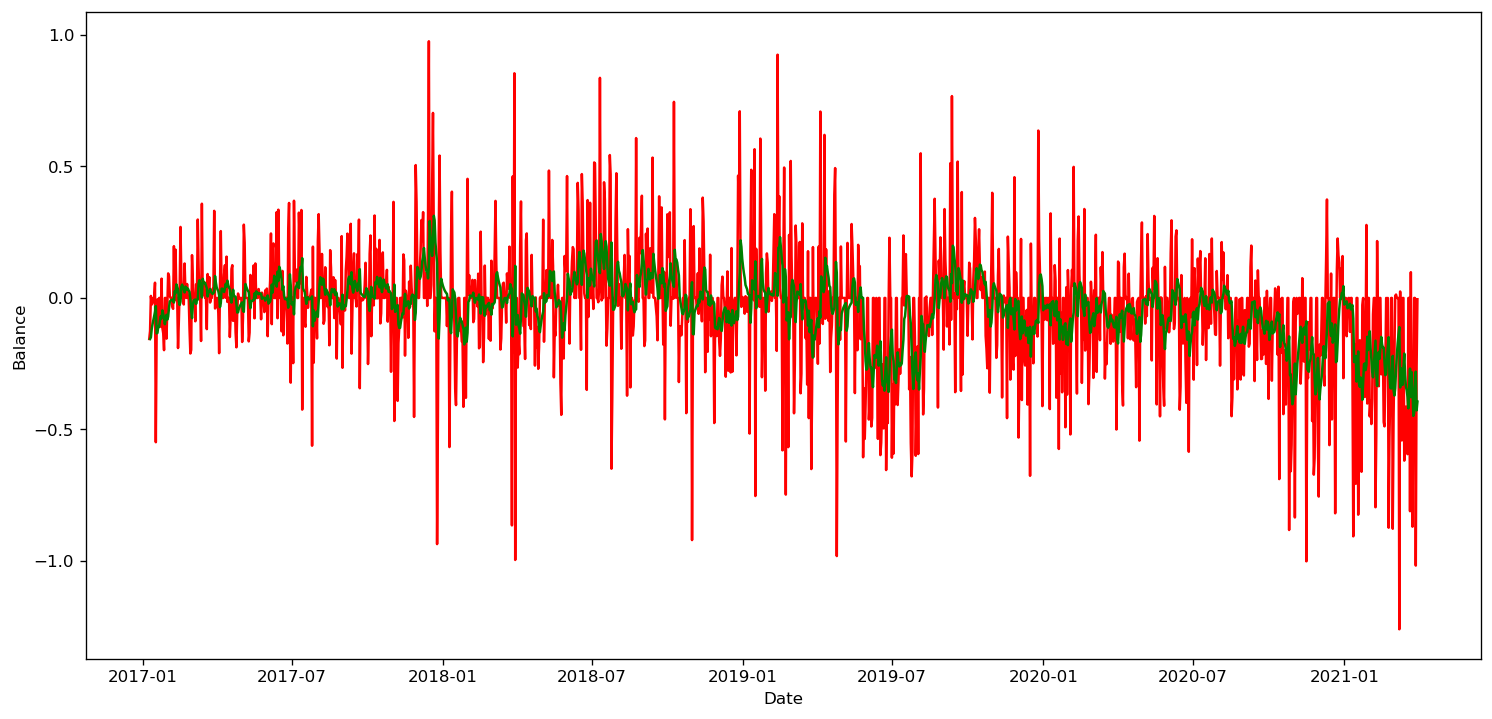

In [170]:
sns.lineplot(new_df.Balance, color='red')
sns.lineplot(new_df.exp_smoothing, color = 'green')

## Сдвиги и rolling window

In [171]:
def rolling_window_stats(window_size):
    new_df[f'min_last_{window_size}'] = new_df.Balance.rolling(7).min().shift(1)
    new_df[f'max_last_{window_size}'] = new_df.Balance.rolling(7).max().shift(1)
    new_df[f'mean_last_{window_size}'] = new_df.Balance.rolling(7).mean().shift(1)
    
    last_min = np.inf
    last_max = - np.inf
    sum = 0

    new_df[f'min_last_{window_size}'].iloc[0] = 0
    new_df[f'max_last_{window_size}'].iloc[0] = 0
    new_df[f'mean_last_{window_size}'].iloc[0] = 0

    for i in range(1,window_size):
        if last_min > new_df.Balance.iloc[i-1]:
            last_min = new_df.Balance.iloc[i-1]
        new_df[f'min_last_{window_size}'].iloc[i] = last_min
        
        if last_max < new_df.Balance.iloc[i-1]:
            last_max = new_df.Balance.iloc[i-1]
        new_df[f'max_last_{window_size}'].iloc[i] = last_max
        
        sum += new_df.Balance.iloc[i-1]
        new_df[f'mean_last_{window_size}'].iloc[i] = sum / i

In [172]:
rolling_window_stats(7)
rolling_window_stats(14)
rolling_window_stats(21)
rolling_window_stats(28)
rolling_window_stats(31)

In [173]:
n_shifts = 8
for i in range(1, n_shifts+1):
    new_df[f'shift_{i}'] = new_df.Balance.shift(i)
new_df = new_df[n_shifts:]

In [174]:
new_df.shape

(1535, 61)

# new_df

In [175]:
new_df

Balance      USD  last_year_GDP  GDP_by_prev_quartal  key_rate  \
Date                                                                          
2017-01-17 -0.548519  59.8588           1.28         24043.612850      10.0   
2017-01-18 -0.124801  59.4025           1.28         24043.612850      10.0   
2017-01-19 -0.005391  59.5544           1.28         24043.612850      10.0   
2017-01-20 -0.113900  59.7304           1.28         24043.612850      10.0   
2017-01-21  0.000000  59.7521           1.28         24043.612850      10.0   
...              ...      ...            ...                  ...       ...   
2021-03-27  0.000000  75.6633           1.49         31230.479404       4.5   
2021-03-28  0.000000  75.6633           1.49         31230.479404       4.5   
2021-03-29 -1.017679  75.6633           1.49         31230.479404       4.5   
2021-03-30 -0.259687  75.6648           1.49         31230.479404       4.5   
2021-03-31 -0.004878  75.8495           1.49         31230.479404       4.5   

            holiday  week_before_holiday  day_before_holiday  spring  summer  \
Date                                                                           
2017-01-17        0                    0                   0       0       0   
2017-01-18        0                    0                   0       0       0   
2017-01-19        0                    0                   0       0       0   
2017-01-20        0                    0                   0       0       0   
2017-01-21        0                    0                   0       0       0   
...             ...                  ...                 ...     ...     ...   
2021-03-27        0                    0                   0       1       0   
2021-03-28        0                    0                   0       1       0   
2021-03-29        0                    0                   0       1       0   
2021-03-30        0                    0                   0       1       0   
2021-03-31        0                    0                   0       1       0   

            ...  max_last_31  mean_last_31   shift_1   shift_2   shift_3  \
Date        ...                                                            
2017-01-17  ...     0.057996     -0.032591  0.057996  0.000000  0.000000   
2017-01-18  ...     0.057996     -0.089916 -0.548519  0.057996  0.000000   
2017-01-19  ...     0.057996     -0.093405 -0.124801 -0.548519  0.057996   
2017-01-20  ...     0.057996     -0.085403 -0.005391 -0.124801 -0.548519   
2017-01-21  ...     0.057996     -0.087778 -0.113900 -0.005391 -0.124801   
...         ...          ...           ...       ...       ...       ...   
2021-03-27  ...     0.098041     -0.366335 -0.393913 -0.869810 -0.587778   
2021-03-28  ...     0.098041     -0.366335  0.000000 -0.393913 -0.869810   
2021-03-29  ...     0.098041     -0.366335  0.000000  0.000000 -0.393913   
2021-03-30  ...     0.098041     -0.395877 -1.017679  0.000000  0.000000   
2021-03-31  ...     0.000000     -0.446981 -0.259687 -1.017679  0.000000   

             shift_4   shift_5   shift_6   shift_7   shift_8  
Date                                                          
2017-01-17 -0.019721 -0.025294  0.007767 -0.125572 -0.155904  
2017-01-18  0.000000 -0.019721 -0.025294  0.007767 -0.125572  
2017-01-19  0.000000  0.000000 -0.019721 -0.025294  0.007767  
2017-01-20  0.057996  0.000000  0.000000 -0.019721 -0.025294  
2017-01-21 -0.548519  0.057996  0.000000  0.000000 -0.019721  
...              ...       ...       ...       ...       ...  
2021-03-27  0.098041 -0.810884  0.000000  0.000000 -0.594002  
2021-03-28 -0.587778  0.098041 -0.810884  0.000000  0.000000  
2021-03-29 -0.869810 -0.587778  0.098041 -0.810884  0.000000  
2021-03-30 -0.393913 -0.869810 -0.587778  0.098041 -0.810884  
2021-03-31  0.000000 -0.393913 -0.869810 -0.587778  0.098041  

[1535 rows x 61 columns]

# Обновим разбиение относительно new_df

In [98]:
mask_before = (new_df.index < threshold_date) & (new_df.index >= start_date)
mask_after = (new_df.index >= threshold_date) & (new_df.index <= end_date)

# Дальше будут пункты с экзогенными факторами, поэтому выделим их заранее

In [99]:
# new_df_train = new_df[new_df.index < threshold_date]
# new_df_test = new_df[mask_after]
exog = list(filter(lambda column: column != 'Balance' and not column.startswith("shift"), new_df.columns))

# Регрессор со внутренним отбором признаков

https://towardsdatascience.com/expand-your-time-series-arsenal-with-these-models-10c807d37558

In [100]:
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.auxmodels import mlp_stack
from tqdm.notebook import tqdm
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

In [204]:
def plot_test_export_summaries(f):
    """ exports the relevant statisitcal information and displays a plot of the test-set results for the last model run
    """
    f.plot_test_set(models=f.estimator,ci=True)
    plt.title(f'{f.estimator} test-set results',size=16)
    plt.show()
    return f.export('model_summaries',determine_best_by='TestSetMAE')[
        [
            'ModelNickname',
            'HyperParams',
            'TestSetMAE',
            'TestSetMAXAE',
            'InSampleMAE',
            'InSampleMAXAE'
        ]
    ]

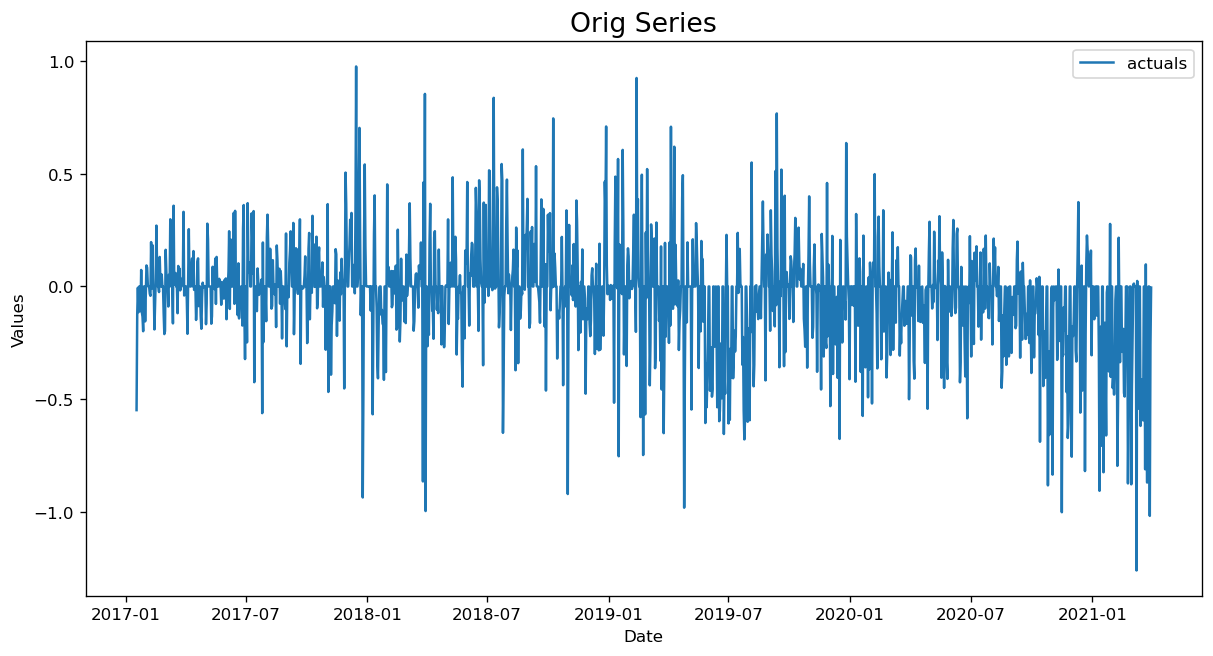

In [205]:
f=Forecaster(y=new_df.Balance,current_dates=new_df.index)
f.plot()
plt.title('Orig Series',size=16)
plt.show()

In [206]:
from scalecast.util import metrics
def maxae(a,f):
    # average of rmse and mae
    return np.max(np.array(a)-np.array(f))
f.add_metric(maxae, 'MAXAE')

In [207]:
fcst_length = 60
f.generate_future_dates(fcst_length)
f.set_test_length(.2)
f.eval_cis() # tell the object to build confidence intervals for all models
f.add_ar_terms(7)
f.add_AR_terms((4,7))
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')
f.set_validation_metric('mae')
f

Forecaster(
    DateStartActuals=2017-01-17T00:00:00.000000000
    DateEndActuals=2021-03-31T00:00:00.000000000
    Freq=D
    N_actuals=1535
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'is_leap_year_True', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', '

In [208]:
f.set_estimator('lasso')
lasso_grid = {'alpha':np.linspace(0,2,100)}
f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast()

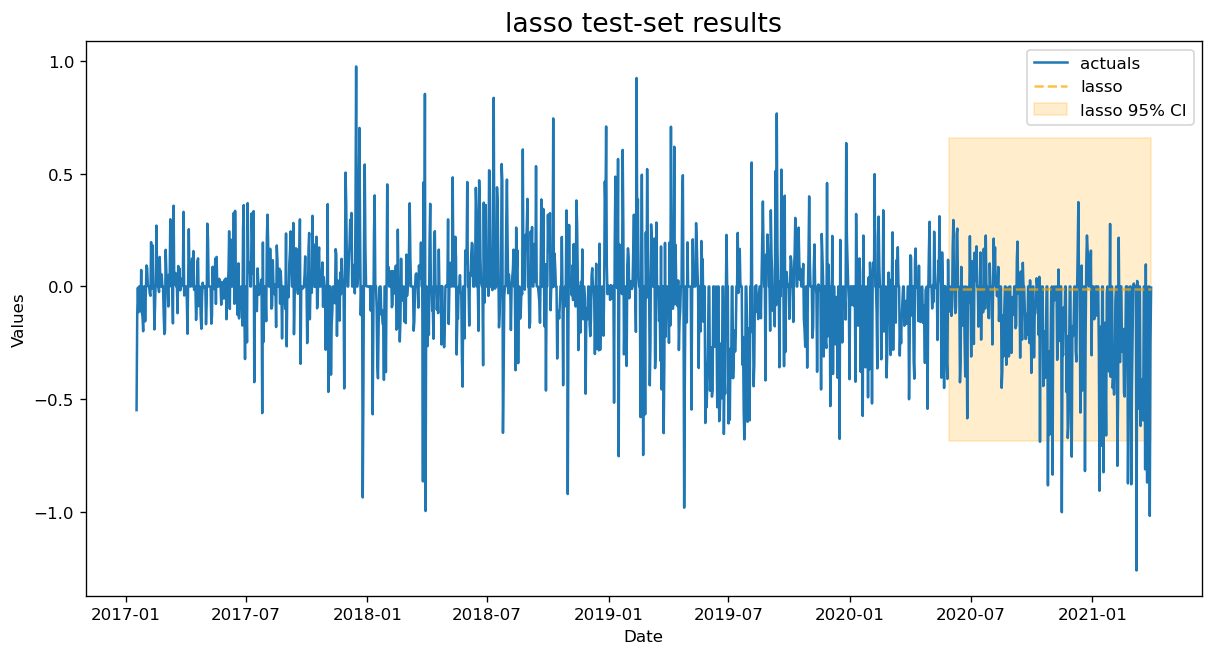

ModelNickname                      HyperParams  TestSetMAE  TestSetMAXAE  \
0         lasso  {'alpha': 0.020202020202020204}    0.187891       0.38639   

   InSampleMAE  InSampleMAXAE  
0     0.159326       1.016421

In [209]:
plot_test_export_summaries(f)

In [210]:
f.set_estimator('ridge')
f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast()
f

Forecaster(
    DateStartActuals=2017-01-17T00:00:00.000000000
    DateEndActuals=2021-03-31T00:00:00.000000000
    Freq=D
    N_actuals=1535
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'is_leap_year_True', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', '

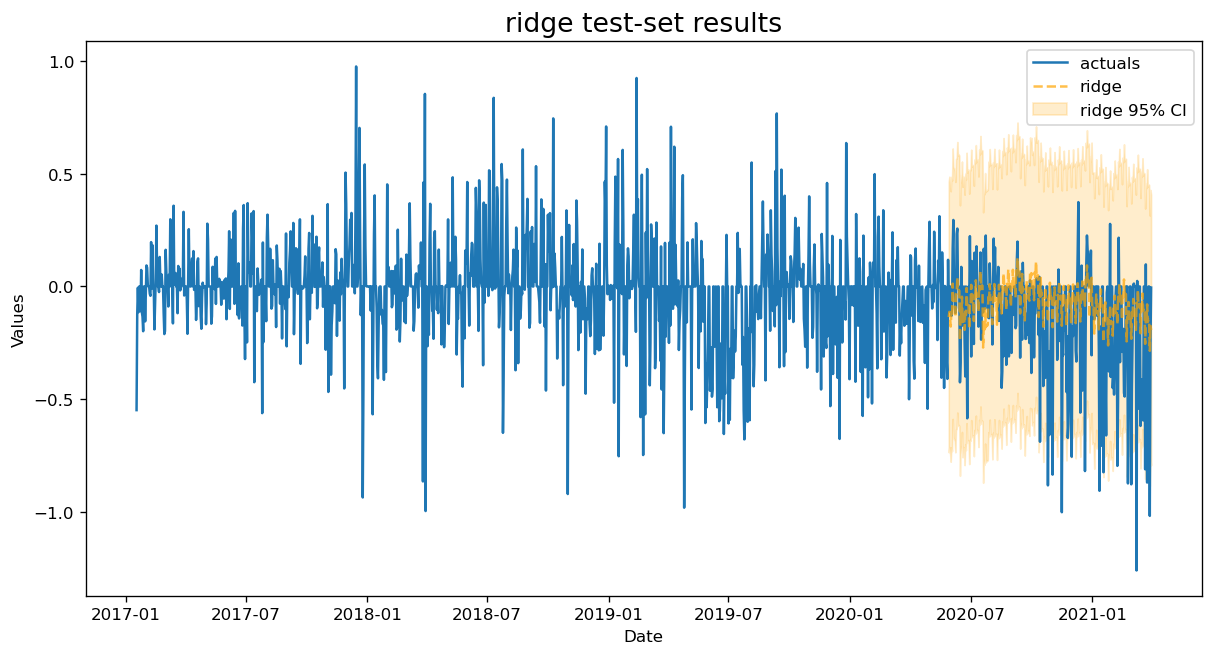

ModelNickname                      HyperParams  TestSetMAE  TestSetMAXAE  \
0         ridge                   {'alpha': 2.0}    0.183837      0.434831   
1         lasso  {'alpha': 0.020202020202020204}    0.187891      0.386390   

   InSampleMAE  InSampleMAXAE  
0     0.142111       0.862625  
1     0.159326       1.016421

In [211]:
plot_test_export_summaries(f)

In [212]:
f.set_estimator('elasticnet')
f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast()

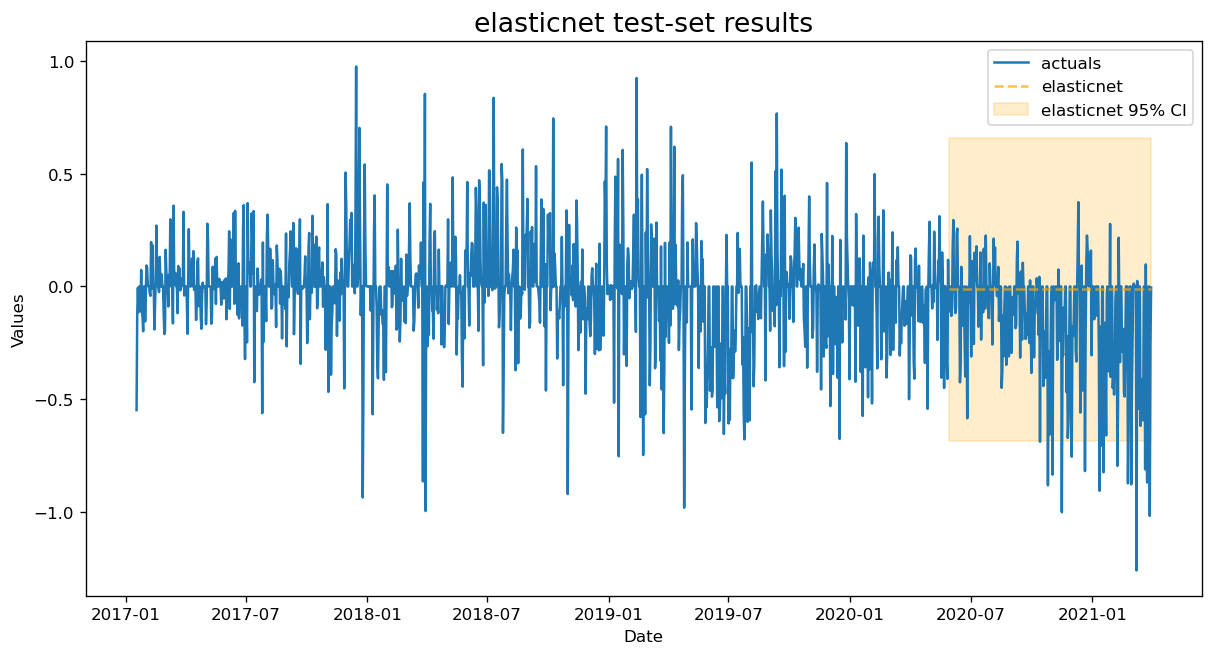

ModelNickname                      HyperParams  TestSetMAE  TestSetMAXAE  \
0         ridge                   {'alpha': 2.0}    0.183837      0.434831   
1    elasticnet   {'alpha': 0.04040404040404041}    0.187891      0.386390   
2         lasso  {'alpha': 0.020202020202020204}    0.187891      0.386390   

   InSampleMAE  InSampleMAXAE  
0     0.142111       0.862625  
1     0.159326       1.016421  
2     0.159326       1.016421

In [213]:
plot_test_export_summaries(f)

# Пытаемся замутить SARIMAX

In [91]:
new_df.columns

Index(['Balance', 'USD', 'last_year_GDP', 'GDP_by_prev_quartal', 'key_rate',
       'holiday', 'week_before_holiday', 'day_before_holiday', 'spring',
       'summer', 'autumn', 'winter', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'avg_Balance_by_this_month', 'weekend',
       'avg_Balance_by_season', 'even_year', 'avg_Balance_by_day', 'tax_day',
       'exp_smoothing', 'min_last_7', 'max_last_7', 'mean_last_7',
       'min_last_14', 'max_last_14', 'mean_last_14', 'min_last_21',
       'max_last_21', 'mean_last_21', 'min_last_28', 'max_last_28',
       'mean_last_28', 'min_last_31', 'max_last_31', 'mean_last_31', 'shift_1',
       'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7',
       'shift_8'],
      dtype='object')

In [92]:
exog

['USD',
 'last_year_GDP',
 'GDP_by_prev_quartal',
 'key_rate',
 'holiday',
 'week_before_holiday',
 'day_before_holiday',
 'spring',
 'summer',
 'autumn',
 'winter',
 'Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'avg_Balance_by_this_month',
 'weekend',
 'avg_Balance_by_season',
 'even_year',
 'avg_Balance_by_day',
 'tax_day',
 'exp_smoothing',
 'min_last_7',
 'max_last_7',
 'mean_last_7',
 'min_last_14',
 'max_last_14',
 'mean_last_14',
 'min_last_21',
 'max_last_21',
 'mean_last_21',
 'min_last_28',
 'max_last_28',
 'mean_last_28',
 'min_last_31',
 'max_last_31',
 'mean_last_31']

In [93]:
import itertools
import math
from sklearn.metrics import r2_score, mean_absolute_error

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 4)  # Moving average order
P_values = range(0, 5) # Seasonal autoregressive order
D_values = range(0,2) # Seasonal differencing order
Q_values = range(0, 3)  # Seasonal moving average order
m_values = [7]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))
results_exog = []

# Initialize AIC with a large value
best_aic_SARIMAX = float("inf")  
best_params_SARIMAX = None
best_SARIMA = None
mask_before = (new_df.index < threshold_date) & (new_df.index >= start_date)
mask_after = (new_df.index >= threshold_date) & (new_df.index <= end_date)

warnings.filterwarnings('ignore')


# Perform grid search
for params in tqdm(param_combinations):
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model_chosen = ARIMA(endog=new_df[mask_before].Balance,
                               exog=new_df[mask_before][exog],
                               order=order, 
                               seasonal_order=seasonal_order)
        model_chosen = model_chosen.fit()
        aic = model_chosen.aic
        
        # Ensure the convergence of the model
        if not math.isinf(model_chosen.zvalues.mean()):
            predict=model_chosen.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])
            err_max = (new_df.Balance[mask_after]-predict).abs().max()
            mae = mean_absolute_error(new_df.Balance[mask_after], predict)
            llf = model_chosen.llf
            r2 = r2_score(new_df.Balance[mask_after], predict)
            aic = model_chosen.aic
            if aic < best_aic_SARIMAX:
                best_aic_SARIMAX = aic
                best_params_SARIMAX = params
                best_SARIMAX = model_chosen
                best_err_max = err_max
                best_mae = mae
                best_llf = llf
                best_r2 = r2
                best_combination = params
                best_aic_SARIMAX = aic
            results_exog.append(list(params[:-1]) + [err_max, mae, llf, r2, aic])
        else:
            print(order, seasonal_order, 'not converged')
    except ValueError as err:
        print('wrong parameters:', params)  
        print(err.args)
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params_SARIMAX)
print("Best AIC:", best_aic_SARIMAX)

  0%|          | 1/480 [00:03<27:41,  3.47s/it]

(0, 0, 0) (0, 0, 0, 7) not converged


  0%|          | 2/480 [00:20<1:21:26, 10.22s/it]


KeyboardInterrupt: 

In [ ]:
result_exog_table = pd.DataFrame(results_exog)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'MAE', 'LLF', 'R2', 'aic']
print("by LLF:")
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(1))
print("by err_max:")
display(result_exog_table.sort_values(by=['err_max'], ascending=True).head(1))
print("by MAE:")
display(result_exog_table.sort_values(by=['MAE'], ascending=True).head(1))
print("by aic:")
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(1))
print("by R2:")
display(result_exog_table.sort_values(by=['R2'], ascending=False).head(1))

In [ ]:
importance = best_SARIMAX.params
# summarize feature importance
for i,v in enumerate(np.abs(importance)):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], np.abs(importance))
plt.show()

In [ ]:
display(result_exog_table.sort_values(by=['MAE'], ascending=True).head(1))

In [ ]:
SARIMAX_by_MAE = ARIMA(endog=new_df[mask_before].Balance,
                               exog=new_df[mask_before][exog],
                               order=(1,0,1), 
                               seasonal_order=(4,1,2,7)).fit()

In [ ]:
display(result_exog_table.sort_values(by=['err_max'], ascending=True).head(1))

In [ ]:
SARIMAX_by_err_max = ARIMA(endog=new_df[mask_before].Balance,
                               exog=new_df[mask_before][exog],
                               order=(3, 0, 3), 
                               seasonal_order=(2,1,1,7)).fit()

In [ ]:
predict_SARIMAX = best_SARIMAX.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])

In [ ]:
predict_SARIMAX_MAE = SARIMAX_by_MAE.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])

In [ ]:
predict_SARIMAX_err_max = SARIMAX_by_err_max.predict(start=threshold_date, end=end_date, exog=new_df[mask_after][exog])

In [ ]:
sns.lineplot(x=new_df.index, y=new_df.Balance, label='Balance', color = 'purple')
sns.lineplot(x=new_df.index[mask_after], y=-predict_SARIMAX, label='pred_chosen', linestyle='dashed', color='red')
# sns.lineplot(x=new_df.index[mask_after], y=predict_SARIMAX_MAE, label='by_MAE', color='darkgreen')
# sns.lineplot(x=new_df.index[mask_after], y=predict_SARIMAX_err_max, label='by_err_max', linestyle='dashed', color='black')
plt.axvline(x=threshold_date)
# sns.lineplot(new_df.exp_smoothing)

In [ ]:
tsplot(SARIMAX_by_err_max.resid, lags=30) 

In [ ]:
tsplot(SARIMAX_by_MAE.resid, lags=30)

In [ ]:
tsplot(best_SARIMAX.resid, lags=30)

In [ ]:
best_SARIMAX.plot_diagnostics()

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
arimax_resid = best_SARIMAX.resid
white_noise_arima = acorr_ljungbox(arimax_resid, lags=None, return_df=True)
white_noise_arima

Все p-value огромные, мы не можем отвергнуть нулевую гипотезу о независимости остатков

In [ ]:
arch_test = sm.stats.diagnostic.het_arch(best_SARIMAX.resid**2)
display(f'ARCH test results:\n')
display(f'LM Statistic: {arch_test[0]}')
display(f'p-value: {arch_test[1]}')
display(f'F Statistic: {arch_test[2]}')
display(f'p-value: {arch_test[3]}')

Вроде как p-value большеват, ARCH эффект нельзя доказать

In [ ]:
tsplot(best_SARIMAX.resid**2, lags=30)

In [ ]:
from arch import arch_model

ps = range(1,15)
qs = range(1,15)

params_variants = list(itertools.product(ps, qs))
results = []

for p, q in tqdm(params_variants):
    amx = arch_model(best_SARIMAX.resid, p=p, q=q).fit()
    
    result = {
        'p': p,
        'q': q,
        'AIC': amx.aic,
    }
    results.append(result)

results_df = pd.DataFrame(results)

best_model_aic = results_df.loc[results_df['AIC'].idxmin()]

display("Best GARCH model (AIC):")
display(best_model_aic)

In [ ]:
p = 11
q = 8
amx = arch_model(best_SARIMAX.resid, p=p, q=q).fit()
fig = amx.plot()

In [ ]:
tsplot(amx.resid)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
garch_resid = amx.resid
white_noise_garch = acorr_ljungbox(garch_resid, lags = [10], return_df=True)
white_noise_garch

In [ ]:
forecast_volatility = am.forecast(start=threshold_date-1, horizon=pd.Timedelta(end_date-threshold_date).days+1)
forecast_volatility_values = forecast_volatility.variance.values[0]

In [ ]:
upper_bound = predict_chosen + np.sqrt(forecast_volatility_values)
lower_bound = predict_chosen - np.sqrt(forecast_volatility_values)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=new_df.index[mask_after], y=predict_SARIMAX, label='pred_chosen', linestyle='dashed', color='red', ax=ax)
# sns.lineplot(x=df.index[mask_after], y=(upper_bound + lower_bound)/2, label='maybe', color = 'magenta')

sns.lineplot(x=new_df.index[mask_after], y=upper_bound, label='bounds', color = 'magenta')
sns.lineplot(x=new_df.index[mask_after], y=lower_bound, label='bounds', color = 'magenta')
sns.lineplot(x=new_df.index[mask_after], y=new_df.Balance[mask_after], label='test', color = 'darkgreen')

# Holt-Winters

In [ ]:
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
new_df.index.freq = 'D'
# Set the value of Alpha and define m (Time Period)
m = 7
alpha = 1/(2*m)

In [ ]:
# HWES1 = SimpleExpSmoothing(new_df['Balance'][mask_before]).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
# new_df[['Balance']][mask_before].plot(title='Holt Winters Single Exponential Smoothing'),
# sns.lineplot(HWES1)

In [ ]:
# HWES2_ADD = ExponentialSmoothing(new_df['Balance'][mask_before],trend='add').fit().fittedvalues

# new_df[['Balance'][mask_before].plot(title='Holt Winters Double Exponential Smoothing: Additive Trend');
# sns.lineplot(HWES2_ADD)

In [ ]:
new_df['posBalance'] = new_df.Balance + np.abs(new_df.Balance.min()) + 1

In [ ]:
HW_model = ExponentialSmoothing(new_df['Balance'][mask_before],trend='add',seasonal='add',seasonal_periods=7).fit()
new_df['HWES3_ADD'] = HW_model.fittedvalues

new_df[['Balance','HWES3_ADD']][mask_before].plot(title='Holt Winters Triple Exponential Smoothing: Additive Seasonality')

In [ ]:
HW_predict = HW_model.forecast(steps=int((end_date - threshold_date).days)+1)

In [ ]:
sns.lineplot(new_df.Balance)
sns.lineplot(HW_model.fittedvalues)
sns.lineplot(HW_predict)

# Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
X = new_df.drop(columns=['Balance', 'HWES3_ADD'])
y = new_df.Balance

X_train, X_test = X[mask_before], X[mask_after]
y_train, y_test = y[mask_before], y[mask_after]

In [ ]:
len(X.columns)

In [ ]:
param_grid_SK = [
    {
        'n_estimators': [300, 1000], 
        'min_samples_leaf': [1, 5, 10, 20, 50], 
        'max_depth': [3, 6, 12],
        'max_features': ['sqrt', 'log2', .01, .5, .1, .5, .9],
        'learning_rate' : [.1, .3, .5, .9], 
        'loss': ['absolute_error']
    },
    {
        'n_estimators': [300, 1000], 
        'min_samples_leaf': [1, 5, 10, 20, 50], 
        'alpha': [0.09] + list(np.logspace(-5, 0, 10, endpoint=True)), 
        'max_depth': [3, 6, 12],
        'max_features': ['sqrt', 'log2', .01, .5, .1, .5, .9],
        'learning_rate' : [.1, .3, .5, .9], 
        'loss': ['quantile']
    }
]
param_grid_XGB = [
    {
        'n_estimators' : [300, 1000], 
        'learning_rate' : [.1, .3, .5, .9], 
        'max_depth': [3, 6, 12], 
        'min_child_weight': [1, 3, 5, 10],
        'grow_policy': ['depthwise', 'losswise'],
        'objective': ['reg:absoluteerror']
     },
    {
        'n_estimators' : [300, 1000], 
        'learning_rate' : [.1, .3, .5, .9], 
        'quantile_alpha' : [0.09] + list(np.logspace(-5, 0, 10, endpoint=True)), 
        'max_depth': [3, 6, 12], 
        'min_child_weight': [1, 3, 5, 10],
        'grow_policy': ['depthwise', 'losswise'],
        'objective': ['reg:quantileerror']
     }
]
param_grid_LGBM = [
    {
        'n_estimators' : [300, 1000], 
        'learning_rate' : [.1, .3, .5, .9], 
        'max_depth': [3, 6, 12], 
        'min_child_samples': [1, 5, 10, 20, 50],
        'num_leaves': [10, 31, 50, 100],
        'objective': ['mae'],
        'njobs': [10]
     },
    {
        'n_estimators' : [300, 1000], 
        'learning_rate' : [.1, .3, .5, .9], 
        'quantile_alpha' : [0.09] + list(np.logspace(-5, 0, 10, endpoint=True)), 
        'min_child_samples': [1, 5, 10, 20, 50],
        'max_depth': [3, 6, 12], 
        'num_leaves': [10, 31, 50, 100],
        'objective': ['quantile'],
        'njobs': [10]
     }
]

In [ ]:
from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar

In [ ]:
import sys
from tqdm.notebook import tqdm
import time
# from tqdm import tqdm if not in notebook
# https://datascience.stackexchange.com/questions/114060/progress-bar-for-gridsearchcv
def fit(model, *args, **kwargs):
    class BarStdout:
        def write(self, text):
            if "totalling" in text and "fits" in text:
                self.bar_size = int(text.split("totalling")[1].split("fits")[0][1:-1])
                self.bar = tqdm(range(self.bar_size))
                self.count = 0
                return
            if "CV" in text and hasattr(self,"bar"):
                self.count += 1
                self.bar.update(n=self.count-self.bar.n)
                if self.count%(self.bar_size//10)==0:
                    time.sleep(0.1)
        def flush(self, text=None):
            pass
    default_stdout= sys.stdout
    sys.stdout = BarStdout()
    model.verbose = 10
    model.fit(*args, **kwargs)
    sys.stdout = default_stdout
    return model

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
# gridSK = GridSearchCVProgressBar(GradientBoostingRegressor(), 
#                        param_grid_SK, 
#                        scoring='neg_mean_absolute_error',
#                        cv=5)
# modelSK = fit(gridSK, X_train, y_train)

In [ ]:
# gridXGB = GridSearchCVProgressBar(XGBRegressor(), 
#                        param_grid_XGB, 
#                        scoring='neg_mean_absolute_error',
#                        cv=5).fit(X_train, y_train)
# modelXGB = fit(gridXGB, X_train, y_train)

In [ ]:
# gridLGBM = GridSearchCVProgressBar(LGBMRegressor(), 
#                        param_grid_LGBM, 
#                        scoring='neg_mean_absolute_error',
#                        cv=5).fit(X_train, y_train)
# modelLGBM = fit(gridLGBM, X_train, y_train)

In [ ]:
# modelSK.best_params_

In [ ]:
# modelXGB.best_params_

In [ ]:
# modelLGBM.best_params_

In [ ]:
modelSK = GradientBoostingRegressor(learning_rate=0.1, loss='absolute_error', max_depth=3, max_features=0.9, min_samples_leaf=20, n_estimators=300).fit(X_train, y_train)

In [ ]:
modelXGB = XGBRegressor(grow_policy='depthwise', learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=300, objective='reg:absoluteerror').fit(X_train, y_train)

In [ ]:
modelLGBM = LGBMRegressor(learning_rate=0.1, max_depth=3, min_child_samples=50, n_estimators=300, njobs=10, num_leaves=10, objective='mae').fit(X_train, y_train)

In [ ]:
predictSK = modelSK.predict(X_test)
predictXGB = modelXGB.predict(X_test)
predictLGBM = modelLGBM.predict(X_test)

In [ ]:
display(f"mean scikit = {(new_df.Balance[mask_after]-predictSK).abs().mean()}")
display(f"mean XGB = {(new_df.Balance[mask_after]-predictXGB).abs().mean()}")
display(f"mean LGBM = {(new_df.Balance[mask_after]-predictLGBM).abs().mean()}")
display(f"max scikit = {(new_df.Balance[mask_after]-predictSK).abs().max()}")
display(f"max XGB = {(new_df.Balance[mask_after]-predictXGB).abs().max()}")
display(f"max LGBM = {(new_df.Balance[mask_after]-predictLGBM).abs().max()}")

In [ ]:
plt.axvline(x=threshold_date, color='magenta')
sns.lineplot(x=new_df.index, y=new_df.Balance, label='test', color = 'purple')
# sns.lineplot(x=new_df.index[mask_after], y=predictSK, label='sklearn', color='red')
sns.lineplot(x=new_df.index[mask_after], y=predictLGBM, label='LGBM', color='blue')
# sns.lineplot(x=new_df.index[mask_after], y=predictXGB, label='XGB', color='darkgreen')